# Top

Inspired from the Darts-based solution by Tom Keldenich: https://inside-machinelearning.com/en/top-1-kaggle-my-method/ but this notebook re-implements the whole algorithm outside of Darts.

Also check my Medium profile, after a few days since this notebook has been posted, for an article about the way the Fourier transform was used here to adjust seasonal features (keywords: seasonal, Fourier).

https://florin-andrei.medium.com/

In [1]:
from pathlib import Path
import os
import gc
import copy
import time
import pickle
import sys

import numpy as np
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt
import plotly.express as px
import plotly.io as pio

import joblib
from joblib import Parallel, delayed
from joblib.externals.loky import get_reusable_executor

from tqdm.notebook import tqdm_notebook as tqdm

from sklearn.metrics import mean_squared_log_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.deterministic import DeterministicProcess
from scipy.signal import periodogram, spectrogram

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

# pandas-2.1 causes some libraries to generate FutureWarning
# will inhibit that where needed
import warnings

In [2]:
plt.style.use('seaborn-v0_8-whitegrid')
plt.rc("figure", autolayout=True, titleweight="bold", figsize=(8, 3))
plt.rc("axes", labelweight="bold", titleweight="bold")
plot_params_base = dict(
    color="0.75",
    style=".-",
    markersize=3,
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

pio.templates.default = "plotly_white"
px.defaults.width = 1200
px.defaults.height = 400

In [3]:
print(f'CPU count: {joblib.cpu_count()}')

CPU count: 16


# Load data sources

In [4]:
input_dir = Path('./input')

train_df = pd.read_csv(input_dir / 'train.csv', parse_dates=['date'])
test_df = pd.read_csv(input_dir / 'test.csv', parse_dates=['date'])
stores_df = pd.read_csv(input_dir / 'stores.csv')
transactions_df = pd.read_csv(input_dir / 'transactions.csv', parse_dates=['date'])
# should be oil_price
oil_df = pd.read_csv(input_dir / 'oil.csv', parse_dates=['date']).rename(columns={'dcoilwtico': 'oil'})
holidays_events_df = pd.read_csv(input_dir / 'holidays_events.csv', parse_dates=['date'])

family_list = train_df['family'].unique().tolist()
num_families = len(family_list)
num_stores = len(train_df['store_nbr'].unique().tolist())

In [5]:
display(train_df)

id       date  store_nbr                      family     sales  \
0              0 2013-01-01          1                  AUTOMOTIVE     0.000   
1              1 2013-01-01          1                   BABY CARE     0.000   
2              2 2013-01-01          1                      BEAUTY     0.000   
3              3 2013-01-01          1                   BEVERAGES     0.000   
4              4 2013-01-01          1                       BOOKS     0.000   
...          ...        ...        ...                         ...       ...   
3000883  3000883 2017-08-15          9                     POULTRY   438.133   
3000884  3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885  3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886  3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887  3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 6 columns]

In [6]:
display(test_df)

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [7]:
display(stores_df)

store_nbr           city                           state type  cluster
0           1          Quito                       Pichincha    D       13
1           2          Quito                       Pichincha    D       13
2           3          Quito                       Pichincha    D        8
3           4          Quito                       Pichincha    D        9
4           5  Santo Domingo  Santo Domingo de los Tsachilas    D        4
5           6          Quito                       Pichincha    D       13
6           7          Quito                       Pichincha    D        8
7           8          Quito                       Pichincha    D        8
8           9          Quito                       Pichincha    B        6
9          10          Quito                       Pichincha    C       15
10         11        Cayambe                       Pichincha    B        6
11         12      Latacunga                        Cotopaxi    C       15
12         13      Latacunga                        Cotopaxi    C       15
13         14       Riobamba                      Chimborazo    C        7
14         15         Ibarra                        Imbabura    C       15
15         16  Santo Domingo  Santo Domingo de los Tsachilas    C        3
16         17          Quito                       Pichincha    C       12
17         18          Quito                       Pichincha    B       16
18         19       Guaranda                         Bolivar    C       15
19         20          Quito                       Pichincha    B        6
20         21  Santo Domingo  Santo Domingo de los Tsachilas    B        6
21         22           Puyo                         Pastaza    C        7
22         23         Ambato                      Tungurahua    D        9
23         24      Guayaquil                          Guayas    D        1
24         25        Salinas                     Santa Elena    D        1
25         26      Guayaquil                          Guayas    D       10
26         27          Daule                          Guayas    D        1
27         28      Guayaquil                          Guayas    E       10
28         29      Guayaquil                          Guayas    E       10
29         30      Guayaquil                          Guayas    C        3
30         31       Babahoyo                        Los Rios    B       10
31         32      Guayaquil                          Guayas    C        3
32         33        Quevedo                        Los Rios    C        3
33         34      Guayaquil                          Guayas    B        6
34         35         Playas                          Guayas    C        3
35         36       Libertad                          Guayas    E       10
36         37         Cuenca                           Azuay    D        2
37         38           Loja                            Loja    D        4
38         39         Cuenca                           Azuay    B        6
39         40        Machala                          El Oro    C        3
40         41        Machala                          El Oro    D        4
41         42         Cuenca                           Azuay    D        2
42         43     Esmeraldas                      Esmeraldas    E       10
43         44          Quito                       Pichincha    A        5
44         45          Quito                       Pichincha    A       11
45         46          Quito                       Pichincha    A       14
46         47          Quito                       Pichincha    A       14
47         48          Quito                       Pichincha    A       14
48         49          Quito                       Pichincha    A       11
49         50         Ambato                      Tungurahua    A       14
50         51      Guayaquil                          Guayas    A       17
51         52          Manta                          Manabi    A       11
52         53          Manta 

In [8]:
display(transactions_df)

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

In [9]:
display(oil_df)

date    oil
0    2013-01-01    NaN
1    2013-01-02  93.14
2    2013-01-03  92.97
3    2013-01-04  93.12
4    2013-01-07  93.20
...         ...    ...
1213 2017-08-25  47.65
1214 2017-08-28  46.40
1215 2017-08-29  46.46
1216 2017-08-30  45.96
1217 2017-08-31  47.26

[1218 rows x 2 columns]

In [10]:
display(holidays_events_df)

date        type    locale locale_name  \
0   2012-03-02     Holiday     Local       Manta   
1   2012-04-01     Holiday  Regional    Cotopaxi   
2   2012-04-12     Holiday     Local      Cuenca   
3   2012-04-14     Holiday     Local    Libertad   
4   2012-04-21     Holiday     Local    Riobamba   
..         ...         ...       ...         ...   
345 2017-12-22  Additional  National     Ecuador   
346 2017-12-23  Additional  National     Ecuador   
347 2017-12-24  Additional  National     Ecuador   
348 2017-12-25     Holiday  National     Ecuador   
349 2017-12-26  Additional  National     Ecuador   

                       description  transferred  
0               Fundacion de Manta        False  
1    Provincializacion de Cotopaxi        False  
2              Fundacion de Cuenca        False  
3        Cantonizacion de Libertad        False  
4        Cantonizacion de Riobamba        False  
..                             ...          ...  
345                      Navidad-3        False  
346                      Navidad-2        False  
347                      Navidad-1        False  
348                        Navidad        False  
349                      Navidad+1        False  

[350 rows x 6 columns]

In [11]:
train_start = train_df['date'].min().date()
train_end = train_df['date'].max().date()
train_len = (train_end - train_start).days + 1

test_start = test_df['date'].min().date()
test_end = test_df['date'].max().date()
test_len = (test_end - test_start).days + 1

family_count = train_df['family'].nunique()
store_count = train_df['store_nbr'].nunique()

## train_df

In [12]:
missing_days = pd.date_range(train_start, train_end).difference(train_df['date'].unique()).strftime('%Y-%m-%d').to_list()
print(f'missing days: {missing_days}')

missing days: ['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25']


In [13]:
# fill in missing days
t_idx = pd.MultiIndex.from_product(
    [pd.date_range(train_start, train_end), train_df['store_nbr'].unique(), train_df['family'].unique()], names=['date', 'store_nbr', 'family']
)
train_df.set_index(['date', 'store_nbr', 'family'], inplace=True)
train_df = train_df.reindex(t_idx).reset_index()
train_df[["sales", "onpromotion"]] = train_df[["sales", "onpromotion"]].fillna(0.0)
train_df

date  store_nbr                      family         id  \
0       2013-01-01          1                  AUTOMOTIVE        0.0   
1       2013-01-01          1                   BABY CARE        1.0   
2       2013-01-01          1                      BEAUTY        2.0   
3       2013-01-01          1                   BEVERAGES        3.0   
4       2013-01-01          1                       BOOKS        4.0   
...            ...        ...                         ...        ...   
3008011 2017-08-15          9                     POULTRY  3000883.0   
3008012 2017-08-15          9              PREPARED FOODS  3000884.0   
3008013 2017-08-15          9                     PRODUCE  3000885.0   
3008014 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES  3000886.0   
3008015 2017-08-15          9                     SEAFOOD  3000887.0   

            sales  onpromotion  
0           0.000          0.0  
1           0.000          0.0  
2           0.000          0.0  
3           0.000          0.0  
4           0.000          0.0  
...           ...          ...  
3008011   438.133          0.0  
3008012   154.553          1.0  
3008013  2419.729        148.0  
3008014   121.000          8.0  
3008015    16.000          0.0  

[3008016 rows x 6 columns]

## oil_df

In [14]:
# fill in missing days
o_idx = pd.Index(pd.date_range(oil_df['date'].min(), oil_df['date'].max()), name='date')
oil_df = oil_df.set_index('date').reindex(o_idx).sort_index()
oil_df.interpolate(method='linear', limit_direction='both', inplace=True)
oil_df = oil_df.reset_index()
oil_df

date        oil
0    2013-01-01  93.140000
1    2013-01-02  93.140000
2    2013-01-03  92.970000
3    2013-01-04  93.120000
4    2013-01-05  93.146667
...         ...        ...
1699 2017-08-27  46.816667
1700 2017-08-28  46.400000
1701 2017-08-29  46.460000
1702 2017-08-30  45.960000
1703 2017-08-31  47.260000

[1704 rows x 2 columns]

## transactions_df

Missing transactions: there are fewer transactions than `number_of_days * number_of_stores`.

For days with zero sales, fill the transactions in with 0. The remaining NaN will be interpolated.

In [15]:
transactions_df

date  store_nbr  transactions
0     2013-01-01         25           770
1     2013-01-02          1          2111
2     2013-01-02          2          2358
3     2013-01-02          3          3487
4     2013-01-02          4          1922
...          ...        ...           ...
83483 2017-08-15         50          2804
83484 2017-08-15         51          1573
83485 2017-08-15         52          2255
83486 2017-08-15         53           932
83487 2017-08-15         54           802

[83488 rows x 3 columns]

In [16]:
print(f'nr of transaction records: {len(transactions_df.index)}')
print(f'store_count * train_len:   {store_count * train_len}')

total_sales = pd.DataFrame(train_df.groupby(by=['date', 'store_nbr'])['sales'].sum())
sales_tran = total_sales.join(transactions_df.set_index(['date', 'store_nbr']))
sales_tran.loc[sales_tran['sales'] == 0, 'transactions'] = 0.0
sales_tran.drop(columns=['sales'], inplace=True)
sales_tran = sales_tran.unstack('store_nbr')
sales_tran = sales_tran.interpolate(method='linear', limit_direction='both')
transactions_df = sales_tran.stack('store_nbr').reset_index()
display(transactions_df)
print(f'nr of transaction records: {len(transactions_df.index)}')

nr of transaction records: 83488
store_count * train_len:   91152


date  store_nbr  transactions
0     2013-01-01          1           0.0
1     2013-01-01          2           0.0
2     2013-01-01          3           0.0
3     2013-01-01          4           0.0
4     2013-01-01          5           0.0
...          ...        ...           ...
91147 2017-08-15         50        2804.0
91148 2017-08-15         51        1573.0
91149 2017-08-15         52        2255.0
91150 2017-08-15         53         932.0
91151 2017-08-15         54         802.0

[91152 rows x 3 columns]

nr of transaction records: 91152


## holidays_events_df

### Show locales

In [17]:
print(f'locale name for national holidays:')
print(f'{sorted(holidays_events_df[holidays_events_df["locale"] == "National"]["locale_name"].unique().tolist())}')

print(f'\nlocale name for regional holidays:')
print(f'{sorted(holidays_events_df[holidays_events_df["locale"] == "Regional"]["locale_name"].unique().tolist())}')

print(f'\nlocale name for local holidays:')
print(f'{sorted(holidays_events_df[holidays_events_df["locale"] == "Local"]["locale_name"].unique().tolist())}')

locale name for national holidays:
['Ecuador']

locale name for regional holidays:
['Cotopaxi', 'Imbabura', 'Santa Elena', 'Santo Domingo de los Tsachilas']

locale name for local holidays:
['Ambato', 'Cayambe', 'Cuenca', 'El Carmen', 'Esmeraldas', 'Guaranda', 'Guayaquil', 'Ibarra', 'Latacunga', 'Libertad', 'Loja', 'Machala', 'Manta', 'Puyo', 'Quevedo', 'Quito', 'Riobamba', 'Salinas', 'Santo Domingo']


### Name variations example

In [18]:
holidays_events_df[(holidays_events_df['description'].str.contains("Navidad")) & (holidays_events_df['date'].dt.year.eq(2012))]

date        type    locale locale_name     description  transferred
31 2012-12-21  Additional  National     Ecuador       Navidad-4        False
33 2012-12-22  Additional  National     Ecuador       Navidad-3        False
34 2012-12-23  Additional  National     Ecuador       Navidad-2        False
35 2012-12-24      Bridge  National     Ecuador  Puente Navidad        False
36 2012-12-24  Additional  National     Ecuador       Navidad-1        False
37 2012-12-25     Holiday  National     Ecuador         Navidad        False
38 2012-12-26  Additional  National     Ecuador       Navidad+1        False

### Remove redundancies in holiday names

Group similar names together. E.g. all "Navidad..." events.

In [19]:
def process_holidays(s):
    """
    Remove place names (etc.) from holiday descriptions.
    """
    if "futbol" in s:
        return "futbol"
    to_remove = list(set(stores_df['city'].str.lower()) | set(stores_df['state'].str.lower()))
    for w in to_remove:
        s = s.replace(w, "")
    return s


holidays_events_df['description'] = (
    holidays_events_df.apply(
        lambda x: x['description'].lower().replace(x['locale_name'].lower(), ""),
        axis=1,
    )
    .apply(process_holidays)
    .replace(
        r"[+-]\d+|\b(de|del|traslado|recupero|puente|-)\b",
        "",
        regex=True,
    )
    .replace(
        r"\s+|-",
        " ",
        regex=True,
    )
    .str.strip()
)

holidays_events_df

date        type    locale locale_name        description  \
0   2012-03-02     Holiday     Local       Manta          fundacion   
1   2012-04-01     Holiday  Regional    Cotopaxi  provincializacion   
2   2012-04-12     Holiday     Local      Cuenca          fundacion   
3   2012-04-14     Holiday     Local    Libertad      cantonizacion   
4   2012-04-21     Holiday     Local    Riobamba      cantonizacion   
..         ...         ...       ...         ...                ...   
345 2017-12-22  Additional  National     Ecuador            navidad   
346 2017-12-23  Additional  National     Ecuador            navidad   
347 2017-12-24  Additional  National     Ecuador            navidad   
348 2017-12-25     Holiday  National     Ecuador            navidad   
349 2017-12-26  Additional  National     Ecuador            navidad   

     transferred  
0          False  
1          False  
2          False  
3          False  
4          False  
..           ...  
345        False  
346        False  
347        False  
348        False  
349        False  

[350 rows x 6 columns]

### Remove transferred holidays

"Transferred" holidays are holidays that are gone, moved to a different date. Let's remove them.

In [20]:
holidays_events_df = holidays_events_df[holidays_events_df['transferred'] == False].drop(columns=['transferred'])
holidays_events_df

date        type    locale locale_name        description
0   2012-03-02     Holiday     Local       Manta          fundacion
1   2012-04-01     Holiday  Regional    Cotopaxi  provincializacion
2   2012-04-12     Holiday     Local      Cuenca          fundacion
3   2012-04-14     Holiday     Local    Libertad      cantonizacion
4   2012-04-21     Holiday     Local    Riobamba      cantonizacion
..         ...         ...       ...         ...                ...
345 2017-12-22  Additional  National     Ecuador            navidad
346 2017-12-23  Additional  National     Ecuador            navidad
347 2017-12-24  Additional  National     Ecuador            navidad
348 2017-12-25     Holiday  National     Ecuador            navidad
349 2017-12-26  Additional  National     Ecuador            navidad

[338 rows x 5 columns]

In [21]:
holidays_events_df['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

### Work Day

`Work Day` is the opposite of a holiday. Save their collection for later, and remove them from the holiday df.

In [22]:
work_days = holidays_events_df[holidays_events_df['type'].eq("Work Day")]
work_days = work_days[["date", "type"]].rename(columns={"type": "work_day"}).reset_index(drop=True)
work_days['work_day'] = work_days['work_day'].notna().astype(int)
work_days

date  work_day
0 2013-01-05         1
1 2013-01-12         1
2 2014-12-20         1
3 2015-01-10         1
4 2016-11-12         1

In [23]:
holidays_events_df = holidays_events_df[holidays_events_df['type'] != "Work Day"].reset_index(drop=True)
holidays_events_df

date        type    locale locale_name        description
0   2012-03-02     Holiday     Local       Manta          fundacion
1   2012-04-01     Holiday  Regional    Cotopaxi  provincializacion
2   2012-04-12     Holiday     Local      Cuenca          fundacion
3   2012-04-14     Holiday     Local    Libertad      cantonizacion
4   2012-04-21     Holiday     Local    Riobamba      cantonizacion
..         ...         ...       ...         ...                ...
328 2017-12-22  Additional  National     Ecuador            navidad
329 2017-12-23  Additional  National     Ecuador            navidad
330 2017-12-24  Additional  National     Ecuador            navidad
331 2017-12-25     Holiday  National     Ecuador            navidad
332 2017-12-26  Additional  National     Ecuador            navidad

[333 rows x 5 columns]

### Extract local, regional, and national holidays

In [24]:
local_holidays = holidays_events_df[holidays_events_df['locale'] == "Local"]
local_holidays = local_holidays[["date", "locale_name", "description"]].rename(columns={"locale_name": "city"}).reset_index(drop=True)
local_holidays = local_holidays[~local_holidays.duplicated()]
local_holidays = pd.get_dummies(local_holidays, columns=["description"], prefix="loc")
local_holidays

date      city  loc_cantonizacion  loc_fundacion  loc_independencia
0   2012-03-02     Manta              False           True              False
1   2012-04-12    Cuenca              False           True              False
2   2012-04-14  Libertad               True          False              False
3   2012-04-21  Riobamba               True          False              False
4   2012-05-12      Puyo               True          False              False
..         ...       ...                ...            ...                ...
143 2017-11-12    Ambato              False          False               True
144 2017-12-05     Quito              False           True              False
145 2017-12-08      Loja              False           True              False
146 2017-12-08     Quito              False           True              False
147 2017-12-22   Salinas               True          False              False

[147 rows x 5 columns]

In [25]:
regional_holidays = holidays_events_df[holidays_events_df['locale'] == "Regional"]
regional_holidays = (
    regional_holidays[["date", "locale_name", "description"]]
    .rename(columns={"locale_name": "state", "description": "provincializacion"})
    .reset_index(drop=True)
)
regional_holidays['provincializacion'] = (regional_holidays['provincializacion'] == "provincializacion").astype(int)
regional_holidays

date                           state  provincializacion
0  2012-04-01                        Cotopaxi                  1
1  2012-06-25                        Imbabura                  1
2  2012-11-06  Santo Domingo de los Tsachilas                  1
3  2012-11-07                     Santa Elena                  1
4  2013-04-01                        Cotopaxi                  1
5  2013-06-25                        Imbabura                  1
6  2013-11-06  Santo Domingo de los Tsachilas                  1
7  2013-11-07                     Santa Elena                  1
8  2014-04-01                        Cotopaxi                  1
9  2014-06-25                        Imbabura                  1
10 2014-11-06  Santo Domingo de los Tsachilas                  1
11 2014-11-07                     Santa Elena                  1
12 2015-04-01                        Cotopaxi                  1
13 2015-06-25                        Imbabura                  1
14 2015-11-06  Santo Domingo de los Tsachilas                  1
15 2015-11-07                     Santa Elena                  1
16 2016-04-01                        Cotopaxi                  1
17 2016-06-25                        Imbabura                  1
18 2016-11-06  Santo Domingo de los Tsachilas                  1
19 2016-11-07                     Santa Elena                  1
20 2017-04-01                        Cotopaxi                  1
21 2017-06-25                        Imbabura                  1
22 2017-11-06  Santo Domingo de los Tsachilas                  1
23 2017-11-07                     Santa Elena                  1

In [26]:
national_holidays = holidays_events_df[holidays_events_df['locale'] == "National"]
national_holidays = national_holidays[["date", "description"]].reset_index(drop=True)
national_holidays = national_holidays[~national_holidays.duplicated()]
national_holidays = pd.get_dummies(national_holidays, columns=["description"], prefix="national", dtype=bool)
# different national holidays may fall on the same day
national_holidays = national_holidays.groupby("date").sum().astype(bool).reset_index()
# shorten name for visualization purposes later
national_holidays = national_holidays.rename(columns={"nat_primer grito independencia": "nat_primer grito"})
# national_holidays = national_holidays.astype(bool)

national_holidays

date  national_batalla  national_black friday  national_carnaval  \
0   2012-08-10             False                  False              False   
1   2012-10-12             False                  False              False   
2   2012-11-02             False                  False              False   
3   2012-11-03             False                  False              False   
4   2012-12-21             False                  False              False   
..         ...               ...                    ...                ...   
150 2017-12-22             False                  False              False   
151 2017-12-23             False                  False              False   
152 2017-12-24             False                  False              False   
153 2017-12-25             False                  False              False   
154 2017-12-26             False                  False              False   

     national_cyber monday  national_dia difuntos  national_dia la madre  \
0                    False                  False                  False   
1                    False                  False                  False   
2                    False                   True                  False   
3                    False                  False                  False   
4                    False                  False                  False   
..                     ...                    ...                    ...   
150                  False                  False                  False   
151                  False                  False                  False   
152                  False                  False                  False   
153                  False                  False                  False   
154                  False                  False                  False   

     national_dia trabajo  national_futbol  national_independencia  \
0                   False            False                   False   
1                   False            False                    True   
2                   False            False                   False   
3                   False            False                    True   
4                   False            False                   False   
..                    ...              ...                     ...   
150                 False            False                   False   
151                 False            False                   False   
152                 False            False                   False   
153                 False            False                   False   
154                 False            False                   False   

     national_navidad  national_primer dia ano  \
0               False                    False   
1               False                    False   
2               False                    False   
3               False                    False   
4                True                    False   
..                ...                      ...   
150              True                    False   
151              True                    False   
152              True                    False   
153              True                    False   
154              True                    False   

     national_primer grito independencia  national_terremoto  \
0                                   True               False   
1                                  False               False   
2                                  False               False   
3                                  False               False   
4                                  False               False   
..                                   ...                 ...   
150                                False               False   
151                                False               False   
152                                False               False   
153                                False               False   
154           

In [27]:
# keep selected national holidays with larger impacts on sales
selected_holidays = [
    "national_terremoto",
    "national_navidad",
    "national_dia la madre",
    "national_dia trabajo",
    "national_primer dia ano",
    "national_futbol",
    "national_dia difuntos",
]
keep_national_holidays = national_holidays[["date", *selected_holidays]]
keep_national_holidays

date  national_terremoto  national_navidad  national_dia la madre  \
0   2012-08-10               False             False                  False   
1   2012-10-12               False             False                  False   
2   2012-11-02               False             False                  False   
3   2012-11-03               False             False                  False   
4   2012-12-21               False              True                  False   
..         ...                 ...               ...                    ...   
150 2017-12-22               False              True                  False   
151 2017-12-23               False              True                  False   
152 2017-12-24               False              True                  False   
153 2017-12-25               False              True                  False   
154 2017-12-26               False              True                  False   

     national_dia trabajo  national_primer dia ano  national_futbol  \
0                   False                    False            False   
1                   False                    False            False   
2                   False                    False            False   
3                   False                    False            False   
4                   False                    False            False   
..                    ...                      ...              ...   
150                 False                    False            False   
151                 False                    False            False   
152                 False                    False            False   
153                 False                    False            False   
154                 False                    False            False   

     national_dia difuntos  
0                    False  
1                    False  
2                     True  
3                    False  
4                    False  
..                     ...  
150                  False  
151                  False  
152                  False  
153                  False  
154                  False  

[155 rows x 8 columns]

# Data

## Build main data pool

In [28]:
model_params = {}
# follow the Darts convention for categorizing features as types of covariates
# only feature prefixes are stored here
# any features that begin with these prefixes are in the same categories

# TODO: oil should not be a future covariate
model_params['covariates'] = {
    'static': ['city', 'state', 'type', 'cluster', 'store_nbr'],
    'past': ['transactions'],
    'future': ['oil', 'onpromotion'],
    'holidays': ['national'],
    'calendar': [
        'day_of_week',
        'day_of_month',
        'day_of_year',
        'month',
        'week_of_year',
        'work_day',
        'year',
    ],
}
# TODO: target lags are between forecast_horizon (16) and 730; default 63
model_params['lag_list'] = {
    'target': {'min': 1, 'max': 63},
    'future': {'min': 1, 'max': 14},
    'holidays': {'min': 1, 'max': 14},
    'past': {'min': 16, 'max': 22},
}
model_params['moving_average_params'] = {'per_store': {'onpromotion': [7, 28]}, 'common': {'oil': [7, 28]}}
# if sales in this many prior days were 0, then forecast should be 0
# this is probably just a hack, but it improves performance
model_params['zero_sales_cutoff'] = 21
# rows will be dropped at the start anyway due to lags creating NaNs
# so for skip_first_n_days to have an effect, it must be greater than the biggest lag
model_params['skip_first_n_days'] = 0
model_params['x_scaler'] = {
    'enabled': True,
}
model_params['y_scaler'] = {
    'enabled': True,
    'y_log': True,
}

model_params['model'] = {
    'lr': {'n_jobs': 1},
    'xgbr': {'n_jobs': 1, 'random_state': 0, 'verbosity': 0},
    'lgbmr': {'n_jobs': 1, 'random_state': 0, 'verbose': -1},
    # 'lgbmr': {'n_jobs': 1, 'random_state': 0, 'verbose': -1, 'force_col_wise': True, 'deterministic': True},
    'cbr': {'thread_count': 1, 'random_state': 0, 'logging_level': 'Silent'},
}

model_params

{'covariates': {'static': ['city', 'state', 'type', 'cluster', 'store_nbr'],
  'past': ['transactions'],
  'future': ['oil', 'onpromotion'],
  'holidays': ['national'],
  'calendar': ['day_of_week',
   'day_of_month',
   'day_of_year',
   'month',
   'week_of_year',
   'work_day',
   'year']},
 'lag_list': {'target': {'min': 1, 'max': 63},
  'future': {'min': 1, 'max': 14},
  'holidays': {'min': 1, 'max': 14},
  'past': {'min': 16, 'max': 22}},
 'moving_average_params': {'per_store': {'onpromotion': [7, 28]},
  'common': {'oil': [7, 28]}},
 'zero_sales_cutoff': 21,
 'skip_first_n_days': 0,
 'x_scaler': {'enabled': True},
 'y_scaler': {'enabled': True, 'y_log': True},
 'model': {'lr': {'n_jobs': 1},
  'xgbr': {'n_jobs': 1, 'random_state': 0, 'verbosity': 0},
  'lgbmr': {'n_jobs': 1, 'random_state': 0, 'verbose': -1},
  'cbr': {'thread_count': 1, 'random_state': 0, 'logging_level': 'Silent'}}}

In [29]:
# merge dataset files
# to reduce the massive redundancy that would occur otherwise (bloating the dataframe sizes),
# per-store data and non-store-specific data are kept separate for now

# per-store features
X_per_store = pd.concat([train_df, test_df], axis=0, ignore_index=True)
X_per_store.drop(columns=['id'], inplace=True)
X_per_store = X_per_store.merge(transactions_df, on=["date", "store_nbr"], how="left")
X_per_store = X_per_store.merge(stores_df, on="store_nbr", how="left")
X_per_store.sort_values(["date", "store_nbr", "family"], ignore_index=True, inplace=True)
# switch some columns to categorical
# data['store_nbr'] = data['store_nbr'].astype(int).astype('category')
X_per_store['store_nbr'] = X_per_store['store_nbr'].astype(str).astype('category')
X_per_store['family'] = X_per_store['family'].astype('category')
X_per_store['city'] = X_per_store['city'].apply(lambda x: (f"{x.lower()}"))
X_per_store['city'] = X_per_store['city'].astype('category')
X_per_store['state'] = X_per_store['state'].apply(lambda x: (f"{x.lower()}"))
X_per_store['state'] = X_per_store['state'].astype('category')
X_per_store['type'] = X_per_store['type'].astype('category')
X_per_store['cluster'] = X_per_store['cluster'].astype(int).astype('category')

# this is Christmas and New Year
# impute them using linear interpolation later, so they behave like regular holidays
# another thing to try is to just leave them alone with zero sales, but that would need to be marked in some way
zero_sales_dates = missing_days + [f"{j}-01-01" for j in range(2013, 2018)]
X_per_store.loc[
    (X_per_store['date'].isin(zero_sales_dates)) & (X_per_store['sales'] == 0) & (X_per_store['onpromotion'] == 0), ["sales", "onpromotion"]
] = np.nan


# interpolate sales and onpromotion now
X_per_store.set_index(['date', 'store_nbr', 'family'], inplace=True)
X_per_store = X_per_store.unstack(['store_nbr', 'family'])

data_train = X_per_store.loc[:train_end].copy()
data_test = X_per_store.loc[test_start:].copy()

data_train = pd.concat(
    [
        data_train,
        data_train[['sales', 'onpromotion']]
        .interpolate(method='linear', limit_direction='both')
        .rename(columns={'sales': 'sales_inter', 'onpromotion': 'onpromotion_inter'}),
    ],
    axis=1,
)
data_train.sort_index(axis=1, inplace=True)
data_train = data_train.drop(columns=['sales', 'onpromotion']).rename(columns={'sales_inter': 'sales', 'onpromotion_inter': 'onpromotion'})

X_per_store = pd.concat([data_train, data_test])
del data_train, data_test
gc.collect()

# TODO: maybe this should be float
X_per_store['onpromotion'] = X_per_store['onpromotion'].astype(int)

# dummy the static covariates
X_per_store = X_per_store.stack(['store_nbr', 'family']).reset_index()
X_per_store['store_nbr_copy'] = X_per_store['store_nbr']
X_per_store = pd.get_dummies(data=X_per_store, columns=model_params['covariates']['static'], prefix_sep='_dummy_', dtype=bool)
X_per_store = X_per_store.rename(columns={'store_nbr_copy': 'store_nbr'})

# from long to wide
X_per_store.set_index(['date', 'store_nbr', 'family'], inplace=True)
X_per_store = X_per_store.unstack(['store_nbr', 'family'])
X_per_store = X_per_store.asfreq('D')

# new column levels order: family, features, store_nbr
X_per_store.columns = X_per_store.columns.reorder_levels([2, 0, 1])
X_per_store.columns.names = ['family', 'features', 'store_nbr']
X_per_store.sort_index(axis=1, inplace=True)

# sales
y_all = X_per_store.xs('sales', axis=1, level='features', drop_level=False)
X_per_store.drop('sales', axis=1, level='features', inplace=True)

display(X_per_store)
display(y_all)

family            AUTOMOTIVE                                                   \
features   city_dummy_ambato                                                    
store_nbr                  1     10     11     12     13     14     15     16   
date                                                                            
2013-01-01             False  False  False  False  False  False  False  False   
2013-01-02             False  False  False  False  False  False  False  False   
2013-01-03             False  False  False  False  False  False  False  False   
2013-01-04             False  False  False  False  False  False  False  False   
2013-01-05             False  False  False  False  False  False  False  False   
...                      ...    ...    ...    ...    ...    ...    ...    ...   
2017-08-27             False  False  False  False  False  False  False  False   
2017-08-28             False  False  False  False  False  False  False  False   
2017-08-29             False  False  False  False  False  False  False  False   
2017-08-30             False  False  False  False  False  False  False  False   
2017-08-31             False  False  False  False  False  False  False  False   

family                    ...      SEAFOOD                                     \
features                  ... type_dummy_E                                      
store_nbr      17     18  ...            5     50     51     52     53     54   
date                      ...                                                   
2013-01-01  False  False  ...        False  False  False  False  False  False   
2013-01-02  False  False  ...        False  False  False  False  False  False   
2013-01-03  False  False  ...        False  False  False  False  False  False   
2013-01-04  False  False  ...        False  False  False  False  False  False   
2013-01-05  False  False  ...        False  False  False  False  False  False   
...           ...    ...  ...          ...    ...    ...    ...    ...    ...   
2017-08-27  False  False  ...        False  False  False  False  False  False   
2017-08-28  False  False  ...        False  False  False  False  False  False   
2017-08-29  False  False  ...        False  False  False  False  False  False   
2017-08-30  False  False  ...        False  False  False  False  False  False   
2017-08-31  False  False  ...        False  False  False  False  False  False   

family                                  
features                                
store_nbr       6      7      8      9  
date                                    
2013-01-01  False  False  False  False  
2013-01-02  False  False  False  False  
2013-01-03  False  False  False  False  
2013-01-04  False  False  False  False  
2013-01-05  False  False  False  False  
...           ...    ...    ...    ...  
2017-08-27  False  False  False  False  
2017-08-28  False  False  False  False  
2017-08-29  False  False  False  False  
2017-08-30  False  False  False  False  
2017-08-31  False  False  False  False  

[1704 rows x 206712 columns]

family     AUTOMOTIVE                                                 ...  \
features        sales                                                 ...   
store_nbr           1   10    11   12   13   14   15   16    17   18  ...   
date                                                                  ...   
2013-01-01        2.0  3.0  12.0  4.0  7.0  8.0  4.0  5.0   8.0  1.0  ...   
2013-01-02        2.0  3.0  12.0  4.0  7.0  8.0  4.0  5.0   8.0  1.0  ...   
2013-01-03        3.0  2.0   8.0  4.0  0.0  0.0  2.0  5.0   1.0  1.0  ...   
2013-01-04        3.0  2.0   5.0  5.0  3.0  5.0  2.0  2.0   1.0  1.0  ...   
2013-01-05        5.0  0.0   7.0  7.0  4.0  8.0  2.0  1.0  10.0  3.0  ...   
...               ...  ...   ...  ...  ...  ...  ...  ...   ...  ...  ...   
2017-08-27        NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...   
2017-08-28        NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...   
2017-08-29        NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...   
2017-08-30        NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...   
2017-08-31        NaN  NaN   NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN  ...   

family        SEAFOOD                                                       \
features        sales                                                        
store_nbr           5      50      51   52   53   54          6          7   
date                                                                         
2013-01-01  11.745000  42.266  97.801  0.0  0.0  3.0  54.538002  59.752000   
2013-01-02  11.745000  42.266  97.801  0.0  0.0  3.0  54.538002  59.752000   
2013-01-03  17.162000  26.147  64.062  0.0  0.0  2.0  43.272000  41.428000   
2013-01-04  15.631001  25.663  94.971  0.0  0.0  2.0  45.703000  57.225998   
2013-01-05  18.779000  32.327  75.149  0.0  0.0  1.0  60.305000  31.939999   
...               ...     ...     ...  ...  ...  ...        ...        ...   
2017-08-27        NaN     NaN     NaN  NaN  NaN  NaN        NaN        NaN   
2017-08-28        NaN     NaN     NaN  NaN  NaN  NaN        NaN        NaN   
2017-08-29        NaN     NaN     NaN  NaN  NaN  NaN        NaN        NaN   
2017-08-30        NaN     NaN     NaN  NaN  NaN  NaN        NaN        NaN   
2017-08-31        NaN     NaN     NaN  NaN  NaN  NaN        NaN        NaN   

family                      
features                    
store_nbr        8       9  
date                        
2013-01-01  72.284  29.214  
2013-01-02  72.284  29.214  
2013-01-03  43.441  25.000  
2013-01-04  49.508  11.000  
2013-01-05  57.611  28.361  
...            ...     ...  
2017-08-27     NaN     NaN  
2017-08-28     NaN     NaN  
2017-08-29     NaN     NaN  
2017-08-30     NaN     NaN  
2017-08-31     NaN     NaN  

[1704 rows x 1782 columns]

In [30]:
X_common = oil_df.copy()
X_common = X_common.merge(work_days, on="date", how="left")
# since only national holidays are kept, they go into the common data
X_common = X_common.merge(keep_national_holidays, on="date", how="left")
# fill columns with 0s to indicate absence of holidays/events
X_common[["work_day", *selected_holidays]] = X_common[["work_day", *selected_holidays]].fillna(0.0).astype(int).astype(bool)

# include date-related future covariates
X_common["month"] = X_common['date'].dt.month.astype(int)
X_common = pd.get_dummies(X_common, columns=['month'], prefix_sep='_dummy_', dtype=bool)
X_common["year"] = X_common['date'].dt.year.astype(int)
X_common = pd.get_dummies(X_common, columns=['year'], prefix_sep='_dummy_', dtype=bool)
X_common["day_of_week"] = X_common['date'].dt.dayofweek.astype(int)
X_common = pd.get_dummies(X_common, columns=['day_of_week'], prefix_sep='_dummy_', dtype=bool)
X_common["day_of_month"] = X_common['date'].dt.day.astype(int)
X_common = pd.get_dummies(X_common, columns=['day_of_month'], prefix_sep='_dummy_', dtype=bool)
# X_common["day_of_year"] = X_common['date'].dt.dayofyear.astype(int)
# X_common = pd.get_dummies(X_common, columns=['day_of_year'], prefix_sep='_dummy_', dtype=bool)
X_common["week_of_year"] = X_common['date'].dt.isocalendar().week.astype(int)
X_common = pd.get_dummies(X_common, columns=['week_of_year'], prefix_sep='_dummy_', dtype=bool)
X_common['days_to_month_end'] = X_common['date'].dt.daysinmonth - X_common['date'].dt.day
X_common = pd.get_dummies(X_common, columns=['days_to_month_end'], prefix_sep='_dummy_', dtype=bool)

# add linear term
# do not add the 'const' term (order=0) since only linear models benefit much from it
X_dp = DeterministicProcess(index=X_common.index, constant=True, order=1).in_sample().astype(int).drop(columns=['const'])
X_common = pd.concat([X_common, X_dp], axis=1)

X_common.set_index('date', inplace=True)
X_common = X_common.asfreq('D')
X_common

oil  work_day  national_terremoto  national_navidad  \
date                                                                    
2013-01-01  93.140000     False               False             False   
2013-01-02  93.140000     False               False             False   
2013-01-03  92.970000     False               False             False   
2013-01-04  93.120000     False               False             False   
2013-01-05  93.146667      True               False             False   
...               ...       ...                 ...               ...   
2017-08-27  46.816667     False               False             False   
2017-08-28  46.400000     False               False             False   
2017-08-29  46.460000     False               False             False   
2017-08-30  45.960000     False               False             False   
2017-08-31  47.260000     False               False             False   

            national_dia la madre  national_dia trabajo  \
date                                                      
2013-01-01                  False                 False   
2013-01-02                  False                 False   
2013-01-03                  False                 False   
2013-01-04                  False                 False   
2013-01-05                  False                 False   
...                           ...                   ...   
2017-08-27                  False                 False   
2017-08-28                  False                 False   
2017-08-29                  False                 False   
2017-08-30                  False                 False   
2017-08-31                  False                 False   

            national_primer dia ano  national_futbol  national_dia difuntos  \
date                                                                          
2013-01-01                     True            False                  False   
2013-01-02                    False            False                  False   
2013-01-03                    False            False                  False   
2013-01-04                    False            False                  False   
2013-01-05                    False            False                  False   
...                             ...              ...                    ...   
2017-08-27                    False            False                  False   
2017-08-28                    False            False                  False   
2017-08-29                    False            False                  False   
2017-08-30                    False            False                  False   
2017-08-31                    False            False                  False   

            month_dummy_1  ...  days_to_month_end_dummy_22  \
date                       ...                               
2013-01-01           True  ...                       False   
2013-01-02           True  ...                       False   
2013-01-03           True  ...                       False   
2013-01-04           True  ...                       False   
2013-01-05           True  ...                       False   
...                   ...  ...                         ...   
2017-08-27          False  ...                       False   
2017-08-28          False  ...                       False   
2017-08-29          False  ...                       False   
2017-08-30          False  ...                       False   
2017-08-31          False  ...                       False   

            days_to_month_end_dummy_23  days_to_month_end_dummy_24  \
date                                                                 
2013-01-01                       False                       False   
2013-01-02                       False                       False   
2013-01-03                       False                       False   
2013-01-04                       False                       False   
2013-01-05                       False       

# Plotting results

In [31]:
def plot_predictions(
    y_gt, fam_list, store_number=None, start_date=None, y_fit=None, y_val=None, y_fore=None, fit_last_date=None, plot_params_base=plot_params_base
):
    """
    Plot ground-truth sales, train-fit predictions, validation predictions, and true forecasts.

    Parameters
    ----------
    y_gt : ground-truth past sales (y_train)
    fam_list : list of product families to plot
    store_number: if None, plot the sum of all stores;
                  if integer, plot only one store
    start_date : crop the start date (left edge) of the graph
    y_fit : predictions on the train dataset (informative only)
    y_val : predictions in validation (on a chunk of X_train)
    y_fore : true forecast predictions on X_test
    """
    plot_params_y = {'marker': '.', 'markersize': 3, 'alpha': 0.5, 'legend': False}
    fig, ax = plt.subplots(len(fam_list), 1, figsize=(8, 1.8 * len(fam_list)))
    if len(fam_list) == 1:
        ax = np.array([ax])
    if store_number == None:
        store_selector = slice(None)
        agg_func = np.sum
    else:
        store_selector = [str(store_number)]
        # identity function
        agg_func = np.array
    for i, f in enumerate(fam_list):
        if store_number == None:
            ax_title = f'{f}'
        else:
            ax_title = f'{f}, store_nbr={store_number}'
        _ = y_gt.loc[start_date:None, (f, store_selector)].apply(agg_func, axis=1, raw=True).plot(**plot_params_base, ax=ax[i], title=ax_title)
        if y_fit is not None:
            _ = y_fit.loc[start_date:fit_last_date, (f, store_selector)].apply(agg_func, axis=1, raw=True).plot(ax=ax[i], **plot_params_y, color='C0')
        if y_val is not None:
            _ = y_val.loc[start_date:None, (f, store_selector)].apply(agg_func, axis=1, raw=True).plot(ax=ax[i], **plot_params_y, color='C1')
        if y_fore is not None:
            _ = y_fore.loc[start_date:None, (f, store_selector)].apply(agg_func, axis=1, raw=True).plot(ax=ax[i], **plot_params_y, color='C3')
        ax[i].set_xlabel('')

# Seasonality

In [32]:
def plot_periodogram(ts, detrend='linear', window='blackmanharris', scaling='density', ts_frequency=None, show_minor_ticks=True, axsize=(12, 3)):
    """
    Take timeseris and plot the periodogram(s).
    If data has multiple columns, one plot is made
    for each column.
    The time period format (df.index.to_period()) is
    preferred for clarity, but any format will work.

    Parameters
    ----------
    ts : DataFrame or Series with data to visualize
    detrend : whether and how to detrend the data
    window : the shape of the time window
    scaling : return either power spectral density
              or power spectrum
    ts_frequency : override timeseries index frequency
                   (for display only, in the xlabel)
    show_minor_ticks : plot minor ticks
    axsize : the size of a single plot in the figure

    Returns
    -------
    Nothing - just displays the figure.

    See scipy.signal.periodogram for more details.
    """

    if not isinstance(ts, pd.Series) and not isinstance(ts, pd.DataFrame):
        raise Exception(f'data must be pd.Series or pd.DataFrame')
    if isinstance(ts, pd.Series):
        ts = pd.DataFrame(ts)

    num_cols = len(ts.columns.to_list())
    fig, ax = plt.subplots(num_cols, 1, figsize=(axsize[0], num_cols * axsize[1]), layout='constrained')
    if num_cols == 1:
        ax = np.array([ax])
    for i in range(num_cols):
        c = ts.columns.to_list()[i]
        frequencies, spectrum = periodogram(
            ts[c],
            fs=1,
            detrend=detrend,
            window=window,
            scaling=scaling,
        )
        with np.errstate(divide='ignore'):
            periods = 1 / frequencies
        ax[i].step(periods, spectrum, color="purple")
        ax[i].set_xscale("log")
        ax[i].xaxis.set_major_formatter('{x:.0f}')
        if show_minor_ticks:
            ax[i].xaxis.set_minor_formatter('{x:.0f}')
            ax[i].grid(visible=True, which='both', axis='both')
        else:
            ax[i].grid(visible=True, which='major', axis='both')
        xlabel = f'period (number of observations)'
        if ts_frequency is not None:
            xlabel += f', freqstr: {ts_frequency}'
        else:
            if hasattr(ts.index, 'freqstr'):
                xlabel += f', freqstr: {ts.index.freqstr}'
        ax[i].set_xlabel(xlabel)
        if scaling == 'density':
            ax[i].set_ylabel("power density")
        else:
            ax[i].set_ylabel("power")
        ax[i].set_title(c)
    fig.suptitle('Periodogram')
    fig.show()


def compute_spectrum(ts_data, max_period, min_amplitude=0.01, detrend='linear'):
    """
    Take timeseries data and compute its Fourier spectrogram.
    E.g.:
    If the time period of the timeseries data is 1 day, then
        max_period=7 will extract components with periods <= 7 days.
    If the time period of the timeseries data is 1 quarter, then
        max_period=4 will look at periods <= 1 year.
    max_period cannot be greater than the length of the data.
    max_period/2 observations are lost at each end of the spectrogram.
    Periods are intervals within the timeseries index.

    Parameters
    ----------
    ts_data : pd.Series() containing the data to be analyzed,
              and its time index
    max_period : the largest period that will be extracted from
                 the signal, measured in number of observations
    min_amplitude : only return components with relative amplitudes
                    higher than this value; 0.0 means 'all'
    detrend : the scipy.signal.spectrogram() detrend argument.
              Options:
              - False
              - 'constant'
              - 'linear'
              - a function

    Returns
    -------
    spectrum : pd.DataFrame
               the index is a subset of the index of the original
                    timeseries data
               the columns are the amplitudes of the various
                    Fourier components
               the column names represent the component periods

    To be useful, each component should be smoothed with
        a time window larger than its period (about 4x).
    """

    nperseg = max_period
    noverlap = nperseg - 1

    frequencies, times, spectrum = spectrogram(x=ts_data, nperseg=nperseg, noverlap=noverlap, detrend=detrend)
    # work around the round-to-nearest-even mode
    times = np.rint(np.nextafter(times, times + 1))
    times = pd.DataFrame({'time_index': times}).astype(int)
    with np.errstate(divide='ignore'):
        periods = pd.DataFrame({'period': 1 / frequencies}).round(decimals=3).astype(str)
    spectrum = pd.DataFrame(spectrum.T, columns=periods['period'].to_list(), index=ts_data.index[times['time_index']])
    relative_amplitudes = spectrum.sum(axis=0) / spectrum.sum(axis=0).max()
    spectrum = spectrum[relative_amplitudes[relative_amplitudes >= min_amplitude].index.to_list()]
    return spectrum


def plot_spectrogram(spectrum, smoothing_window=4, log_amplitude=False, figsize_x=12, figsize_y=None):
    """
    Take a pd.DataFrame() with a signal spectrum,
    and plot its spectrogram.
    Also plot the variation in time of the envelope
    (average value, or amplitude) of each spectral component.

    Parameters
    ----------
    spectrum : pd.DataFrame() with the signal spectrum.
               The index is a subset of the timeseries index.
               Columns are named after the period of
                    each component.
    smoothing_window : Smooth the data with a multiple of the
                       greatest period. Default is 4. Reduce it
                       if max_period is a large fraction of
                       the dataset length, or else the plot
                       will be inaccurate at the edges.
    log_amplitude : Plot envelopes on a log scale.
    figsize_x : Horizontal size of the plot.
    figsize_y : Default None. The vertical size is computed,
                    depending on the number of components.
                If not None, the size is forced to this value.

    Returns
    -------
    No return, it just plots the spectrogram.
    """
    if figsize_y == None:
        figsize_y = min(max(2 * len(spectrum.columns.to_list()), 6), 40)
    periods = [p for p in spectrum.columns.astype(float).to_list() if p not in [np.inf]]
    max_period = max(periods)

    fig, ax = plt.subplots(2, 1, figsize=(figsize_x, figsize_y))

    ax[0].pcolormesh(spectrum.index.astype(str).to_list(), spectrum.columns.to_list(), spectrum.T, cmap='viridis', shading='auto')
    ax[0].xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(nbins=round(figsize_x), min_n_ticks=2))
    ax[0].tick_params(axis='x', labelrotation=45)
    ax[0].grid(visible=True, which='both', axis='both')
    ax[0].set_ylabel('period')
    ax[0].set_xlabel('time index')
    ax[0].set_title('spectrogram')

    ax[1].set_ylabel('amplitude')
    ax[1].set_xlabel('time index')
    ax[1].set_title(f'component envelopes, smoothed {smoothing_window}x')
    spectrum = spectrum.rolling(window=round(smoothing_window * max_period), min_periods=1, center=True, win_type='blackmanharris').sum()
    spectrum.plot(ax=ax[1], logy=log_amplitude)
    ax[1].grid(visible=True, which='both', axis='both')
    ax[1].legend(title='components')

    fig.suptitle('Fourier visualization')
    fig.set_layout_engine(layout='tight')
    fig.show()

## Variations of the 7-day seasonal component

Most product families have strong 7-day seasonal components: sales go up then down then back up again following a weekly pattern.

Modeling this component with fixed-amplitude time dummies would work, but is not optimal.

Better solution: extract the envelope (the variations in time of the strength) of the weekly component, smooth it with a linear model (a.k.a. envelope model), then modify the time dummies so that their amplitude is not fixed, but instead follows the pattern of the envelope. This needs to happen on a per-family basis, since the envelopes are different.

The envelope is extracted with the Fourier transform.

Check my Medium profile, in a few days I will have an article there explaining the technique (key words: seasonal, Fourier):

https://florin-andrei.medium.com/

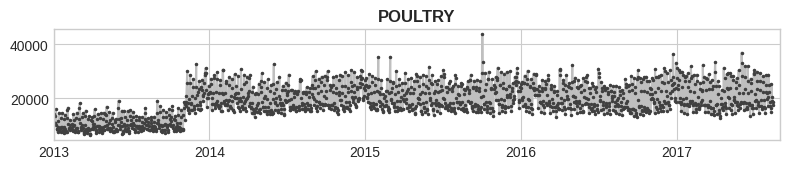

In [33]:
plot_predictions(y_all, ['POULTRY'])

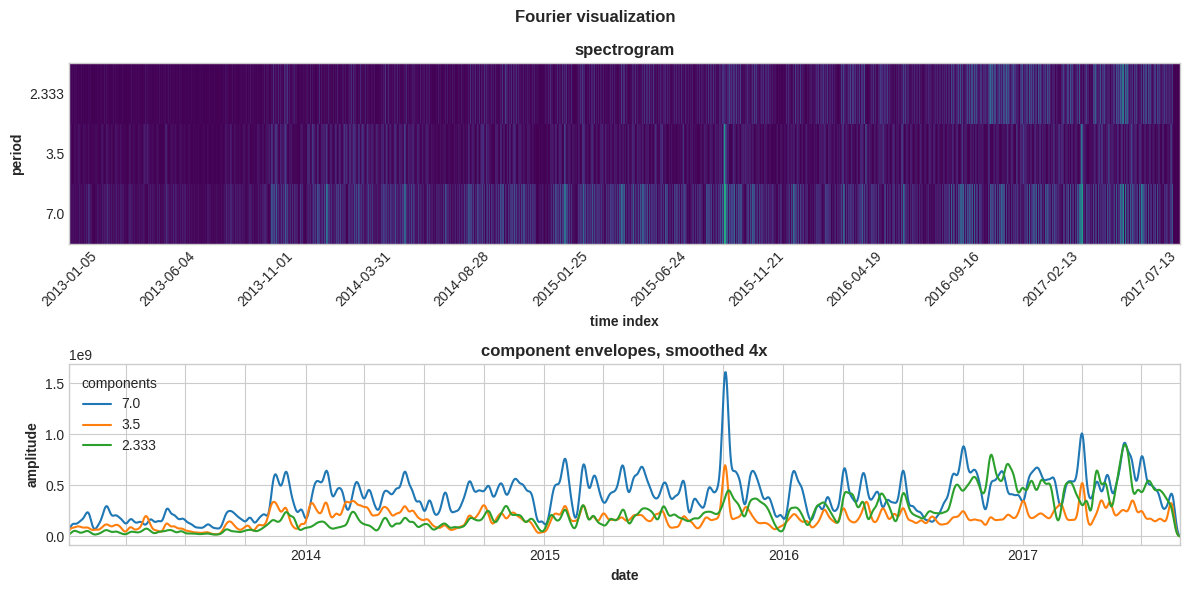

In [34]:
spectrum = compute_spectrum(y_all['POULTRY'].sum(axis=1), 7, min_amplitude=0.1, detrend='linear')
plot_spectrogram(spectrum, smoothing_window=4, log_amplitude=False, figsize_x=12, figsize_y=None)

## Choose product families for envelope processing

Not all product families have a significant variation of the envelope of the 7-day component. Those that don't have enough variation are left alone.

In [35]:
# modify the 7-day time dummies
seasonality_period = 7
cutoff_ratio = 0.5
ffw = []
for i, f in enumerate(family_list):
    ts_fam = y_all[f].droplevel('features', axis=1).sum(axis=1)
    # plot_periodogram(ts_fam)
    spectrum = compute_spectrum(ts_fam, max_period=seasonality_period, min_amplitude=0.1)
    # plot_spectrogram(spectrum, smoothing_window=7)

    frequencies, spectrum_notime = periodogram(ts_fam, fs=1, detrend='linear', window='blackmanharris', scaling='density')
    with np.errstate(divide='ignore'):
        periods = 1 / frequencies
    periodogram_df = pd.DataFrame({'periods': periods, 'spectrum': spectrum_notime})
    periodogram_df.set_index('periods', inplace=True)
    # find index closest to the seasonality period
    closest_to_period = min(periodogram_df.index.to_list(), key=lambda x: abs(x - seasonality_period))
    idx_closest = periodogram_df.index.to_list().index(closest_to_period)
    # find max value closest to seasonality period
    max_closest = periodogram_df.iloc[idx_closest - 2 : idx_closest + 3].max().values[0]
    # find overall max value
    max_overall = periodogram_df.max().values[0]
    ratio_of_max = max_closest / max_overall
    if ratio_of_max >= cutoff_ratio:
        ffw.append(f)

model_params['fourier_families_day_of_week'] = ffw
print('families where Fourier day-of-week trends will be applied:')
print(model_params['fourier_families_day_of_week'])

families where Fourier day-of-week trends will be applied:
['AUTOMOTIVE', 'BEAUTY', 'BEVERAGES', 'BREAD/BAKERY', 'CLEANING', 'DAIRY', 'DELI', 'EGGS', 'GROCERY I', 'GROCERY II', 'HARDWARE', 'LINGERIE', 'LIQUOR,WINE,BEER', 'MEATS', 'PERSONAL CARE', 'POULTRY', 'PREPARED FOODS', 'SEAFOOD']


# Classes and functions

## Scalers for features and target

The features and the target may be processed, before they are sent to the models, in various ways: scaling, log-transform, etc.

Doing this with sklearn transformers and pipelines would require changes to the algorithm, so we're not using them here.

In [36]:
class X_log_scaler:
    """
    Take a Pandas dataframe with columns multi-indexed on 2 levels.
    Apply a scaler to the dataframe.
    Optionally skip columns on level 0 that start with some pattern.
    """

    def __init__(self, scaler, skip_pattern=None, enabled=True):
        self.scaler = scaler
        self.skip_pattern = skip_pattern
        self.enabled = enabled

    def fit(self, df):
        df = df.copy()
        if self.enabled:
            if self.skip_pattern is not None:
                self.columns_to_process = [c for c in df.columns.get_level_values(0).unique() if not c.startswith(self.skip_pattern)]
            else:
                self.columns_to_process = slice(None)
            self.scaler = self.scaler.fit(df.loc[:, (self.columns_to_process, slice(None))])
        return self

    def transform(self, df):
        df = df.copy()
        if self.enabled:
            df.loc[:, (self.columns_to_process, slice(None))] = self.scaler.transform(df.loc[:, (self.columns_to_process, slice(None))])
        return df

    def inverse_transform(self, df):
        df = df.copy()
        if self.enabled:
            df.loc[:, (self.columns_to_process, slice(None))] = self.scaler.inverse_transform(df.loc[:, (self.columns_to_process, slice(None))])
        return df


class y_log_scaler:
    """
    Direct: np.log1p(), then scale.
    Inverse: inverse-scale, then np.expm1().
    """

    def __init__(self, scaler, enabled=True, y_log=True):
        self.scaler = scaler
        self.enabled = enabled
        self.y_log = y_log

    def fit(self, df):
        df = df.copy()
        if self.enabled:
            if self.y_log:
                self.scaler = self.scaler.fit(np.log1p(df))
            else:
                self.scaler = self.scaler.fit(df)
        return self

    def transform(self, df):
        df = df.copy()
        if self.enabled:
            if self.y_log:
                df = pd.DataFrame(self.scaler.transform(np.log1p(df)), index=df.index, columns=df.columns)
            else:
                df = pd.DataFrame(self.scaler.transform(df), index=df.index, columns=df.columns)
        return df

    def inverse_transform(self, df):
        df = df.copy()
        if self.enabled:
            if self.y_log:
                df = pd.DataFrame(np.expm1(self.scaler.inverse_transform(df)), index=df.index, columns=df.columns)
            else:
                df = pd.DataFrame(self.scaler.inverse_transform(df), index=df.index, columns=df.columns)
        return df

## Pre-process data: moving averages and lags

Create time-dependent features such as moving averages and lagged features.

The reason why this is not done just once, before all models are trained, is to allow dynamic changes to these features (different lags, etc) as models are fine-tuned with different parameters.

In [37]:
def make_lags(df, column_patterns, lags, skip_pattern=None, multiplier=1, keep_original=False):
    """
    column_patterns : list of patterns for column.startswith();
                     any column that begins with one of the patterns
                     will be processed
    lags : min/max lags to create
    multiplier : for long-form dataframes, the shift is multiplied by
                 the product of cardinalities of non-date index levels
    keep_original : whether to keep the non-lagged column
    """
    df = df.copy()
    columns = [c for c in df.columns.to_list() if c.startswith(tuple(column_patterns))]
    if skip_pattern is not None:
        columns = [c for c in columns if skip_pattern not in c]
    if len(columns) == 0:
        print(f'could not find columns with patterns {column_patterns}')
        return df
    df_col_list = []
    for c in columns:
        df_lag_list = []
        for l in range(lags['min'], lags['max'] + 1):
            df_lag = pd.DataFrame(index=df.index)
            if l == 0:
                continue
            df_lag[f'{c}_lag{str(l)}'] = df[c].shift(l * multiplier)
            df_lag_list.append(df_lag)
        df_col_list.append(pd.concat(df_lag_list, axis=1))
    df = pd.concat([df] + df_col_list, axis=1)
    if not keep_original and lags['min'] * lags['max'] > 0:
        df.drop(columns=columns, inplace=True)
    return df


def fix_df_column_types(df, bool_col_prefix, int_col_prefix, skip_pattern=None):
    """
    Columns matching name prefix patterns will be reset to bool and int.
    """
    df = df.copy()
    bool_columns = [c for c in df.columns.to_list() if c.startswith(tuple(bool_col_prefix))]
    int_columns = [c for c in df.columns.to_list() if c.startswith(tuple(int_col_prefix))]
    if skip_pattern is not None:
        bool_columns = [c for c in bool_columns if skip_pattern not in c]
        int_columns = [c for c in int_columns if skip_pattern not in c]
    df[bool_columns] = df[bool_columns].astype(bool)
    df[int_columns] = df[int_columns].astype(int)
    # print(df.columns.to_list())
    return df


def preproc_data_pool(df_per_store, df_common, model_params):
    """
    Pre-process a product family. Create moving averages, create lags.
    All moving averages and lags are parametrized, so the features can be fine-tuned dynamically.
    """
    df_per_store = df_per_store.copy()
    df_common = df_common.copy()

    # keep track of boolean and int columns, the dtypes need to be restored later
    bool_cols_orig = []
    int_cols_orig = []
    bool_cols_orig += df_per_store.stack('store_nbr').select_dtypes(['bool']).columns.to_list()
    bool_cols_orig += df_common.select_dtypes(['bool']).columns.to_list()
    int_cols_orig += df_per_store.stack('store_nbr').select_dtypes(['int']).columns.to_list()
    int_cols_orig += df_common.select_dtypes(['int']).columns.to_list()

    # create moving averages
    ma_string = 'moving_average'
    for c, window_list in model_params['moving_average_params']['per_store'].items():
        for w in window_list:
            df_per_store = df_per_store.join(df_per_store[[c]].rolling(window=w, min_periods=1, center=False).mean(), rsuffix=f'_{ma_string}_{str(w)}')
    for c, window_list in model_params['moving_average_params']['common'].items():
        for w in window_list:
            df_common = df_common.join(df_common[[c]].rolling(window=w, min_periods=1, center=False).mean(), rsuffix=f'_{ma_string}_{str(w)}')

    # create lags
    df_per_store_columns_names = df_per_store.columns.names
    df_per_store = df_per_store.stack(['store_nbr'])
    # dataframe is stacked, lags will have to be multiplied by the product of level cardinalities
    stacked_lag_multiplier = len(df_per_store.index.get_level_values('store_nbr').unique())

    df_per_store = make_lags(df_per_store, model_params['covariates']['future'], model_params['lag_list']['future'], 'dummy', stacked_lag_multiplier, True)
    df_common = make_lags(df_common, model_params['covariates']['future'], model_params['lag_list']['future'], 'dummy', 1, True)
    df_common = make_lags(df_common, model_params['covariates']['holidays'], model_params['lag_list']['holidays'], 'dummy', 1, True)
    df_per_store = make_lags(df_per_store, model_params['covariates']['past'], model_params['lag_list']['past'], 'dummy', stacked_lag_multiplier, False)
    df_per_store = make_lags(df_per_store, ['sales'], model_params['lag_list']['target'], 'dummy', stacked_lag_multiplier, False)

    # lags have created several NaN rows at the top, drop them
    fdwn_list = []
    for df in [df_per_store, df_common]:
        # find first day without NaN in all dataframes
        days_without_nan = df.isna().sum(axis=1).groupby(['date']).sum() == 0
        fdwn_list.append(days_without_nan[days_without_nan].index[0])
    first_day_without_nan = max(fdwn_list)
    df_per_store = df_per_store.loc[pd.IndexSlice[first_day_without_nan:, :, :], :]
    df_common = df_common.loc[first_day_without_nan:, :]

    # making lags has converted bool columns to object, and int columns to float, convert them back to keep memory usage low
    df_per_store = fix_df_column_types(df_per_store, bool_cols_orig, int_cols_orig, ma_string)
    df_common = fix_df_column_types(df_common, bool_cols_orig, int_cols_orig, ma_string)
    # need to return wide-form df
    df_per_store = df_per_store.unstack(['store_nbr'])
    df_per_store.columns.names = df_per_store_columns_names
    return df_per_store, df_common


def apply_fourier_trends(y_train, dummy_df, dummy_col_pattern, period, order=2, return_envelope=False):
    """
    For the train target, extract the envelope (i.e. trend) of the target's Fourier component with some period.
    Train a linear model on the envelope. Generate envelope predictions (extrapolate) over the entire dataset.
    Multiply the period dummies with the envelope. Instead of 0 or 1, the dummies will be float numbers.
    Return the modified dataframe with the dummies.

    'order' is for the deterministic components of the linear model that fits the envelope. order=1 is linear fit.
    """
    y_train = y_train.copy()
    dummy_df = dummy_df.copy()

    # extract the main series, summed over all stores
    y_train = y_train.stack('features').sum(axis=1).unstack('features').iloc[:, 0]
    # compute spectrum for y_train, keep only the main period column
    spectrum = compute_spectrum(y_train, period)[[str(float(period))]]
    # generate deterministic components for the whole dummy_df
    dp_terms = DeterministicProcess(index=dummy_df.index, constant=True, order=order).in_sample()
    # fit a linear model on the main spectrum component for y_train
    env_model = LinearRegression()
    env_model.fit(dp_terms.loc[spectrum.index[0] : spectrum.index[-1]], spectrum)
    # using the model, predict a spectrum component for the whole extent of dummy_df
    envelope = pd.Series(
        env_model.predict(dp_terms).reshape(
            -1,
        ),
        index=dp_terms.index,
        name=str(float(period)),
    )
    envelope = envelope / envelope.mean(axis=0)
    cols_to_proc = [c for c in dummy_df.columns if c.startswith(dummy_col_pattern)]
    for c in cols_to_proc:
        dummy_df[c] = dummy_df[c] * envelope
    if return_envelope:
        return dummy_df, envelope
    else:
        return dummy_df


TEST_PREPROC = True
if TEST_PREPROC:
    # f = 'AUTOMOTIVE'
    f = 'BOOKS'
    print(f'family: {f}')
    X_per_store_fam = X_per_store[f].copy()
    X_common_fam = X_common.copy()
    y_fam = y_all[f].copy()
    y_train = y_fam.loc[:train_end].copy()

    y_scaler = y_log_scaler(MinMaxScaler())
    _ = y_scaler.fit(y_train)
    y_train = y_scaler.transform(y_train)
    X_per_store_fam = X_per_store_fam.join(y_train, on='date')
    if f in model_params['fourier_families_day_of_week']:
        X_common_fam_proc, envelope = apply_fourier_trends(y_train, X_common_fam, 'day_of_week', 7, 2, True)
        envelope.plot(title='y Fourier envelope')
    else:
        X_common_fam_proc = X_common_fam.copy()
    X_per_store_fam_proc, X_common_fam_proc = preproc_data_pool(X_per_store_fam, X_common_fam_proc, model_params)
    X_per_store_fam_proc = X_per_store_fam_proc.stack('store_nbr')
    X_all_fam = X_per_store_fam_proc.join(X_common_fam_proc, on='date')
    X_all_fam = X_all_fam.unstack('store_nbr')
    X_all_fam.columns.names = ['features', 'store_nbr']
    X_train = X_all_fam.loc[:train_end]
    X_test = X_all_fam.loc[test_start:]
    X_scaler = X_log_scaler(MinMaxScaler(), skip_pattern='sales_lag')
    _ = X_scaler.fit(X_train)
    X_train_stacked = X_scaler.transform(X_train).stack('store_nbr').swaplevel().sort_index()
    display(X_all_fam)

family: BOOKS


features   city_dummy_ambato                                                   \
store_nbr                  1     10     11     12     13     14     15     16   
date                                                                            
2013-03-05             False  False  False  False  False  False  False  False   
2013-03-06             False  False  False  False  False  False  False  False   
2013-03-07             False  False  False  False  False  False  False  False   
2013-03-08             False  False  False  False  False  False  False  False   
2013-03-09             False  False  False  False  False  False  False  False   
...                      ...    ...    ...    ...    ...    ...    ...    ...   
2017-08-27             False  False  False  False  False  False  False  False   
2017-08-28             False  False  False  False  False  False  False  False   
2017-08-29             False  False  False  False  False  False  False  False   
2017-08-30             False  False  False  False  False  False  False  False   
2017-08-31             False  False  False  False  False  False  False  False   

features                  ... national_dia difuntos_lag14                \
store_nbr      17     18  ...                           5     50     51   
date                      ...                                             
2013-03-05  False  False  ...                       False  False  False   
2013-03-06  False  False  ...                       False  False  False   
2013-03-07  False  False  ...                       False  False  False   
2013-03-08  False  False  ...                       False  False  False   
2013-03-09  False  False  ...                       False  False  False   
...           ...    ...  ...                         ...    ...    ...   
2017-08-27  False  False  ...                       False  False  False   
2017-08-28  False  False  ...                       False  False  False   
2017-08-29  False  False  ...                       False  False  False   
2017-08-30  False  False  ...                       False  False  False   
2017-08-31  False  False  ...                       False  False  False   

features                                                     
store_nbr      52     53     54      6      7      8      9  
date                                                         
2013-03-05  False  False  False  False  False  False  False  
2013-03-06  False  False  False  False  False  False  False  
2013-03-07  False  False  False  False  False  False  False  
2013-03-08  False  False  False  False  False  False  False  
2013-03-09  False  False  False  False  False  False  False  
...           ...    ...    ...    ...    ...    ...    ...  
2017-08-27  False  False  False  False  False  False  False  
2017-08-28  False  False  False  False  False  False  False  
2017-08-29  False  False  False  False  False  False  False  
2017-08-30  False  False  False  False  False  False  False  
2017-08-31  False  False  False  False  False  False  False  

[1641 rows x 28080 columns]

## Run family model

Train a model and generate predictions for one product family.

Various modes are supported:

- validation (limited to X_train / y_train)
- forecast (train on X_train / y_train, predict on X_test)
- fit on X_train / y_train, predict on the whole X_train at once (sanity check for the model)

In validation and forecast modes, predictions are done one day at a time, and these predictions are used as target lags for subsequent predictions.

In [38]:
def run_family_model(
    mod,
    family,
    df_per_store_fam,
    df_common,
    y_fam,
    mod_params,
    train_end,
    test_start,
    validation_mode=False,
    val_train_end=None,
    val_test_start=None,
    val_test_end=None,
    forecast_mode=False,
):
    """
    Train a model and generate predictions for one product family.
    Validation mode will run on the train part of the data only.
    Forecast mode will fit on train and predict on test.
    Non-validation-non-forecast mode will fit and predict on train (just to see how the model behaves).

    Return a dict with: family name, performance metrics (if any), and predictions.

    Memory usage is high, so gc.collect() is frequently invoked.
    That's okay-ish, since this function runs in separate worker processes,
    so the blast radius is limited.
    """
    m_params = copy.deepcopy(mod_params)
    if mod == 'lr':
        model = LinearRegression(**m_params['model'][mod])
    if mod == 'xgbr':
        model = XGBRegressor(**m_params['model'][mod])
        # print(model.get_params())
    if mod == 'lgbmr':
        model = LGBMRegressor(**m_params['model'][mod])
        # print(model.get_params())
    if mod == 'cbr':
        model = CatBoostRegressor(**m_params['model'][mod])

    X_per_store_fam = df_per_store_fam.copy()
    X_common_fam = df_common.copy()
    y_fam = y_fam.copy()
    # the main dataframes are assumed to have the same number of rows at this point
    # and are all in wide format
    assert len(X_per_store_fam.index) == len(X_common_fam.index)
    assert len(X_common_fam.index) == len(y_fam.index)
    first_day = y_fam.index[m_params['skip_first_n_days']]

    if validation_mode:
        y_train = y_fam.loc[:val_train_end]
        y_test = y_fam.loc[val_test_start:val_test_end]
    else:
        y_train = y_fam.loc[:train_end]
        y_test = y_fam.loc[test_start:]
    del y_fam

    y_scaler = y_log_scaler(MinMaxScaler(), enabled=m_params['y_scaler']['enabled'], y_log=m_params['y_scaler']['y_log'])
    # skip first n days, if any, for scaler.fit() but don't drop rows yet
    _ = y_scaler.fit(y_train.loc[first_day:])
    y_train = y_scaler.transform(y_train)

    # join y_train with X first, and then skip n days
    # or else X will have lots of NaNs at the top
    X_per_store_fam = X_per_store_fam.join(y_train, on='date')
    y_train = y_train.loc[first_day:]

    # weekly time dummies are adjusted in amplitude based on the Fourier transform
    # of the target for this family
    # when weekly variation is low, the time dummies get low values
    # when weekly variation is high, the time dummies get high values
    # this replaces the standard [0, 1] time dummy values
    if family in m_params['fourier_families_day_of_week']:
        X_common_fam = apply_fourier_trends(y_train, X_common_fam, 'day_of_week', 7, order=2, return_envelope=False)
    X_per_store_fam, X_common_fam = preproc_data_pool(X_per_store_fam, X_common_fam, m_params)

    X_per_store_fam = X_per_store_fam.stack('store_nbr')
    X_all_fam = X_per_store_fam.join(X_common_fam, on='date')
    del X_per_store_fam, X_common_fam
    gc.collect()
    X_all_fam = X_all_fam.unstack('store_nbr')
    X_all_fam.columns.names = ['features', 'store_nbr']
    # this must happen after preproc_data_pool() since rows will be dropped there anyway
    X_all_fam = X_all_fam.loc[first_day:]

    if validation_mode:
        X_train = X_all_fam.loc[:val_train_end]
        X_test = X_all_fam.loc[val_test_start:val_test_end]
    else:
        X_train = X_all_fam.loc[:train_end]
        X_test = X_all_fam.loc[test_start:]
    del X_all_fam
    # X_train has shed NaN rows at the top, adjust y_train to the same start date
    y_train = y_train.loc[X_train.index[0] :]

    X_scaler = X_log_scaler(MinMaxScaler(), skip_pattern='sales_lag', enabled=m_params['x_scaler']['enabled'])
    _ = X_scaler.fit(X_train)

    X_train_stacked = X_scaler.transform(X_train).stack('store_nbr').swaplevel().sort_index()
    # y_train is transformed already
    y_train_stacked = y_train.stack('store_nbr').swaplevel().sort_index()
    del X_train
    gc.collect()

    # xgboost-2.0 triggers warnings from pandas-2.1
    warnings.simplefilter(action="ignore", category=FutureWarning)
    _ = model.fit(X_train_stacked, y_train_stacked)

    if not validation_mode and not forecast_mode:
        # predict-on-train mode:
        # fit on X_train/y_train, predict on X_train
        # this is just to check how well the model learns trends, seasonality, etc.
        y_predict = pd.DataFrame(model.predict(X_train_stacked), index=X_train_stacked.index)
        del X_train_stacked, y_train_stacked
        gc.collect()
        y_predict = y_predict.unstack('store_nbr')
        y_predict = y_scaler.inverse_transform(y_predict)
        y_predict.clip(lower=0.0, inplace=True)
        y_predict.columns.set_names(['family', 'store_nbr'], inplace=True)
        y_predict.columns = y_predict.columns.set_levels([family], level='family')
        gc.collect()
        return family, {'performance': None, 'predictions': y_predict}
    else:
        del X_train_stacked, y_train_stacked
        gc.collect()
        # features that are X-transformed (not part of skip_pattern) are known in advance
        # so they can all be transformed at once, here:
        X_test = X_scaler.transform(X_test)
        y_pred_list = []
        for d in X_test.index:
            X_step = X_test.loc[d:d]
            for i, pred in enumerate(y_pred_list):
                # Predictions on previous days are filling here the current day sales lags.
                # In validation, the lags are known, but must still be replaced.
                # In forecasting, they are unknown.
                X_step.loc[:, f'sales_lag{str(i+1)}'] = pred.values
            X_step_stacked = X_step.stack('store_nbr').swaplevel().sort_index()
            del X_step
            y_pred_step = pd.DataFrame(model.predict(X_step_stacked), index=X_step_stacked.index)
            del X_step_stacked
            y_pred_step = y_pred_step.unstack('store_nbr').droplevel(0, axis=1)
            # set zero forecasts for target series where the recent observations are 0s
            for c in y_pred_step.columns:
                recent_sales = y_train[[('sales', c)]].iloc[-m_params['zero_sales_cutoff'] :].values.sum()
                if recent_sales == 0:
                    y_pred_step[c] = 0.0
            y_pred_list.append(y_pred_step)
        del X_test
        gc.collect()
        y_forecast = pd.concat(y_pred_list)
        del y_pred_list
        y_forecast = y_scaler.inverse_transform(y_forecast)
        y_forecast.clip(lower=0.0, inplace=True)
        y_forecast.columns = pd.MultiIndex.from_product([[family], y_forecast.columns.to_list()], names=['family', 'store_nbr'])
        if validation_mode:
            fam_perf = mean_squared_log_error(y_test, y_forecast, squared=False)
        else:
            fam_perf = None
        del y_test
        gc.collect()
        return family, {'performance': fam_perf, 'predictions': y_forecast, 'model': model}


TEST_FAMILY_MODEL = False
if TEST_FAMILY_MODEL:
    f = family_list[0]
    test_mod = 'lgbmr'
    val_train_end = '2017-07-30'
    val_test_start = '2017-07-31'

    """
    fit_out = run_family_model(
        test_mod,
        f,
        X_per_store[f],
        X_common,
        y_all[f],
        model_params,
        train_end,
        test_start,
        validation_mode=False,
        forecast_mode=False,
    )
    """

    val_out = run_family_model(
        mod=test_mod,
        family=f,
        df_per_store_fam=X_per_store[f],
        df_common=X_common,
        y_fam=y_all[f],
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
        validation_mode=True,
        val_train_end=val_train_end,
        val_test_start=val_test_start,
        val_test_end=train_end,
        forecast_mode=False,
    )

    """
    plot_predictions(
        y_all.loc[:train_end],
        [f],
        store_number=None,
        y_fit=fit_out['predictions'].loc[:val_train_end],
        y_val=val_out['predictions'],
    )
    """

## Train fit

Fit one model for each family in train data, and then predict on train data again.

This is just to visualize how well the model follow trends, seasonality, cyclic phenomena, etc in training.

In [39]:
def fit_all(mod, df_per_store, df_common, y_all, mod_params, train_end, test_start, family_list=family_list, n_jobs=-1):
    """
    Fit models in parallel for all product families on X_train / y_train.
    Generate predictions on X_train.

    Return mean RMSLE and the predictions.
    (Mean RMSLE is useless here, but is returned for consistency.)
    """
    m_params = copy.deepcopy(mod_params)
    df_per_store = df_per_store.copy()
    df_common = df_common.copy()
    y_all = y_all.copy()

    with Parallel(n_jobs=n_jobs) as parallel:
        results = parallel(
            delayed(run_family_model)(mod, f, df_per_store[f], df_common, y_all[f], m_params, train_end, test_start, validation_mode=False, forecast_mode=False)
            for f in family_list
        )
    results = dict(results)
    get_reusable_executor().shutdown(wait=True)
    y_fit = pd.concat([results[k]['predictions'] for k in results.keys()], axis=1)

    return y_fit

## Validation

In [40]:
def validate_all(
    mod,
    df_per_store,
    df_common,
    y_all,
    mod_params,
    train_end,
    test_start,
    validation_len=16,
    validation_folds=1,
    family_list=family_list,
    n_jobs=-1,
    return_preds=True,
    print_fam_rmsle=True,
):
    """
    Run validation for all product families in parallel.
    Return mean RMSLE and, optionally, the predictions.
    """
    m_params = copy.deepcopy(mod_params)
    df_per_store = df_per_store.copy()
    df_common = df_common.copy()
    y_all = y_all.copy()

    train_index = df_per_store.loc[:train_end].index
    y_pred_val_fold_list = []
    mean_rmsle_fold_list = []
    fold_fam_res_list = []
    for f in range(validation_folds - 1, -1, -1):
        vstart = -((f + 1) * validation_len)
        tstop = vstart - 1
        if f == 0:
            vstop = None
        else:
            vstop = -(f * validation_len)
        fold_index = train_index[tstop:vstop]
        val_train_end = fold_index[0]
        val_test_start = fold_index[1]
        val_test_end = fold_index[-1]

        with Parallel(n_jobs=n_jobs) as parallel:
            results = parallel(
                delayed(run_family_model)(
                    mod=mod,
                    family=f,
                    df_per_store_fam=df_per_store[f],
                    df_common=df_common,
                    y_fam=y_all[f],
                    mod_params=m_params,
                    train_end=train_end,
                    test_start=test_start,
                    validation_mode=True,
                    val_train_end=val_train_end,
                    val_test_start=val_test_start,
                    val_test_end=val_test_end,
                    forecast_mode=False,
                )
                for f in family_list
            )
        results = dict(results)
        get_reusable_executor().shutdown(wait=True)

        y_pred_val_fold = pd.concat([results[k]['predictions'] for k in results.keys()], axis=1)
        y_pred_val_fold_list.append(y_pred_val_fold)

        mean_rmsle_fold = np.mean([res['performance'] for res in results.values()])
        mean_rmsle_fold_list.append(mean_rmsle_fold)
        if print_fam_rmsle:
            print(f'fold {f} RMSLE: {mean_rmsle_fold:.5f}')
            # print()
            fold_fam_res = {}
            # max_fam_len = max([len(f) for f in results.keys()])
            for fam, res in results.items():
                fold_fam_res[fam] = res['performance']
                # print(f'{fam.ljust(max_fam_len)} {res["performance"]:.5f}')
            fold_fam_res = pd.DataFrame(fold_fam_res, index=[f'fold{f}'])
            fold_fam_res.sort_index(axis=1, inplace=True)
            fold_fam_res_list.append(fold_fam_res)

    if print_fam_rmsle:
        fold_res_all = pd.concat(fold_fam_res_list)
        fold_res_all = fold_res_all.T
        display(fold_res_all)

    mean_rmsle = np.mean(mean_rmsle_fold_list)
    if return_preds:
        y_pred_val = pd.concat(y_pred_val_fold_list)
        return mean_rmsle, y_pred_val
    else:
        return mean_rmsle

## Forecast

In [41]:
def forecast_all(mod, df_per_store, df_common, y_all, mod_params, train_end, test_start, family_list=family_list, n_jobs=-1):
    """
    Run forecast for all product families in parallel.
    Return the predictions.
    """
    m_params = copy.deepcopy(mod_params)
    df_per_store = df_per_store.copy()
    df_common = df_common.copy()
    y_all = y_all.copy()

    with Parallel(n_jobs=n_jobs) as parallel:
        results = parallel(
            delayed(run_family_model)(
                mod=mod,
                family=f,
                df_per_store_fam=df_per_store[f],
                df_common=df_common,
                y_fam=y_all[f],
                mod_params=m_params,
                train_end=train_end,
                test_start=test_start,
                validation_mode=False,
                forecast_mode=True,
            )
            for f in family_list
        )
    results = dict(results)
    get_reusable_executor().shutdown(wait=True)
    y_forecast = pd.concat([results[k]['predictions'] for k in results.keys()], axis=1)

    return y_forecast

# Models testing: fit, validation, forecast

In [42]:
RUN_LR = False
RUN_LGBMR = True

RUN_TRAIN_FIT = True
RUN_VALIDATION = True
RUN_FORECAST = True

DO_PLOTS = True

y_forecast_final = None
validation_len = 16
validation_folds = 1

## LinearRegression

### Train fit

In [43]:
if RUN_LR and RUN_TRAIN_FIT:
    y_fit_lr = fit_all(
        mod='lr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
    )
    if DO_PLOTS:
        plot_predictions(y_all.loc[:train_end], family_list, store_number=None, y_fit=y_fit_lr)
else:
    y_fit_lr = None

### Validation

In [44]:
if RUN_LR and RUN_VALIDATION:
    val_rmsle_lr, y_pred_val_lr = validate_all(
        mod='lr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
        validation_len=validation_len,
        validation_folds=validation_folds,
        family_list=family_list,
        n_jobs=-1,
        return_preds=True,
        print_fam_rmsle=True,
    )
    fit_last_date_lr = y_pred_val_lr.index[0]
    print()
    print(f'mean RMSLE: {val_rmsle_lr:.5f}')

    if DO_PLOTS:
        plot_predictions(
            y_all.loc[:train_end], family_list, store_number=None, start_date='2016-01-01', y_fit=y_fit_lr, y_val=y_pred_val_lr, fit_last_date=fit_last_date_lr
        )
else:
    val_rmsle_lr = None
    y_pred_val_lr = None
    fit_last_date_lr = None

### Forecast

In [45]:
if RUN_LR and RUN_FORECAST:
    y_forecast_lr = forecast_all(
        mod='lr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
        family_list=family_list,
        n_jobs=-1,
    )
    y_forecast_final = y_forecast_lr

    if DO_PLOTS:
        plot_predictions(
            y_all.loc[:train_end],
            family_list,
            store_number=None,
            start_date='2016-01-01',
            y_fit=y_fit_lr,
            y_val=y_pred_val_lr,
            y_fore=y_forecast_lr,
            fit_last_date=y_pred_val_lr.index[0],
        )
else:
    y_forecast_lr = None

## LGBMRegressor

### Train fit

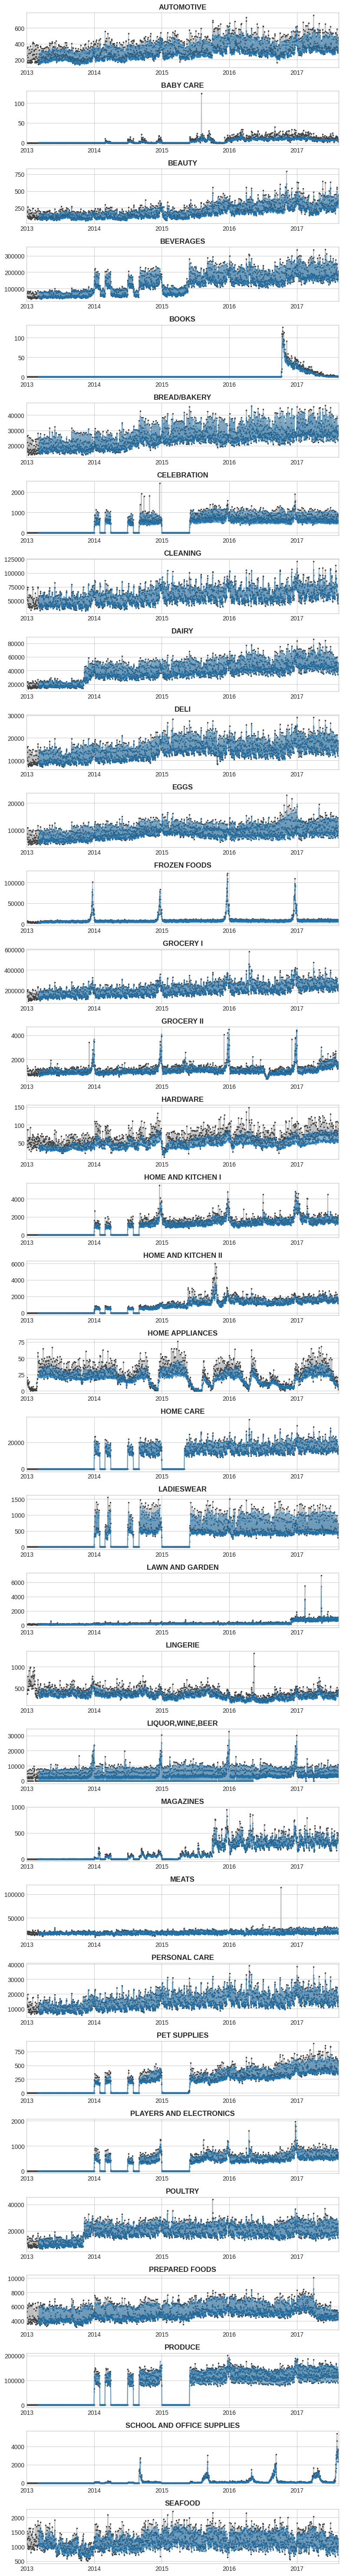

In [46]:
if RUN_LGBMR and RUN_TRAIN_FIT:
    y_fit_lgbmr = fit_all(
        mod='lgbmr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
    )
    if DO_PLOTS:
        plot_predictions(y_all.loc[:train_end], family_list, store_number=None, y_fit=y_fit_lgbmr)
else:
    y_fit_lgbmr = None

### Validation

fold 0 RMSLE: 0.35057


fold0
AUTOMOTIVE                  0.497723
BABY CARE                   0.205705
BEAUTY                      0.465888
BEVERAGES                   0.236952
BOOKS                       0.053537
BREAD/BAKERY                0.181035
CELEBRATION                 0.524457
CLEANING                    0.283739
DAIRY                       0.166171
DELI                        0.181665
EGGS                        0.272489
FROZEN FOODS                0.272219
GROCERY I                   0.171977
GROCERY II                  0.566175
HARDWARE                    0.519902
HOME AND KITCHEN I          0.490049
HOME AND KITCHEN II         0.424609
HOME APPLIANCES             0.268460
HOME CARE                   0.231099
LADIESWEAR                  0.428100
LAWN AND GARDEN             0.340646
LINGERIE                    0.629499
LIQUOR,WINE,BEER            0.460215
MAGAZINES                   0.531427
MEATS                       0.200067
PERSONAL CARE               0.228929
PET SUPPLIES                0.462983
PLAYERS AND ELECTRONICS     0.445603
POULTRY                     0.212605
PREPARED FOODS              0.255946
PRODUCE                     0.170232
SCHOOL AND OFFICE SUPPLIES  0.729926
SEAFOOD                     0.458870


mean RMSLE: 0.35057


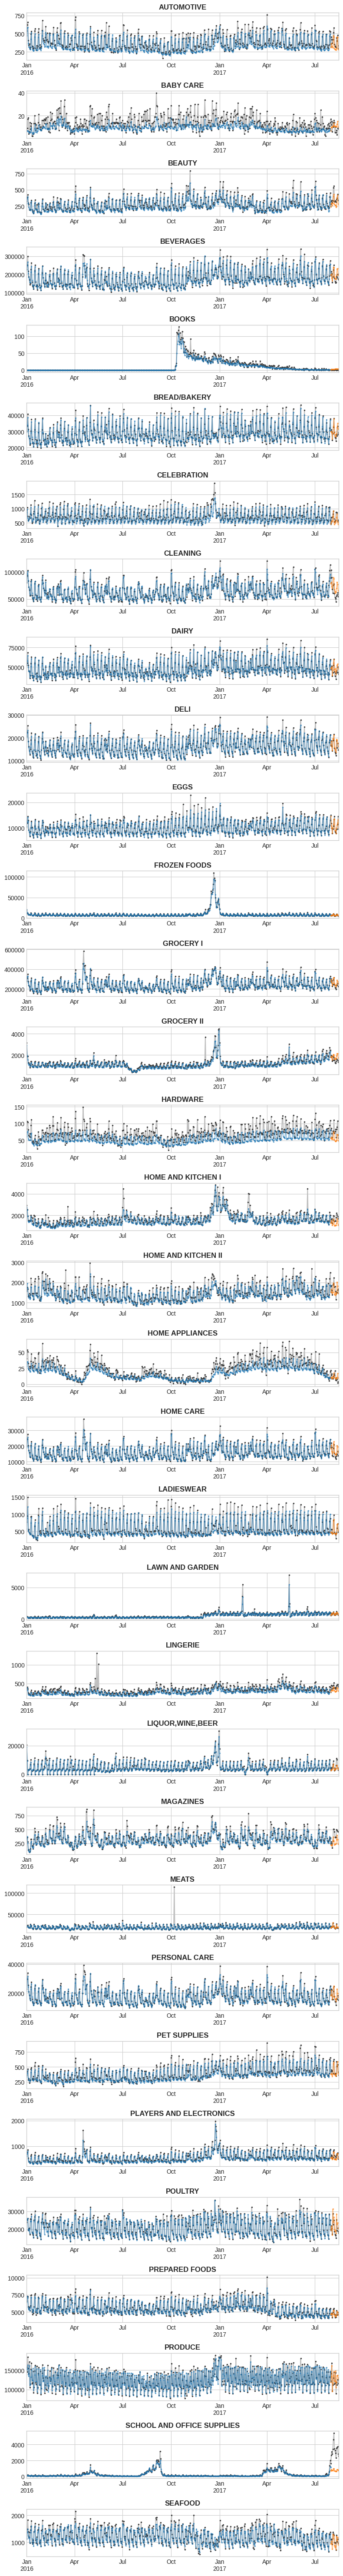

In [47]:
if RUN_LGBMR and RUN_VALIDATION:
    val_rmsle_lgbmr, y_pred_val_lgbmr = validate_all(
        mod='lgbmr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
        validation_len=validation_len,
        validation_folds=validation_folds,
        family_list=family_list,
        n_jobs=-1,
        return_preds=True,
        print_fam_rmsle=True,
    )
    fit_last_date_lgbmr = y_pred_val_lgbmr.index[0]
    print()
    print(f'mean RMSLE: {val_rmsle_lgbmr:.5f}')

    if DO_PLOTS:
        plot_predictions(
            y_all.loc[:train_end],
            family_list,
            store_number=None,
            start_date='2016-01-01',
            y_fit=y_fit_lgbmr,
            y_val=y_pred_val_lgbmr,
            fit_last_date=fit_last_date_lgbmr,
        )
else:
    val_rmsle_lgbmr = None
    y_pred_val_lgbmr = None
    fit_last_date_lgbmr = None

### Forecast

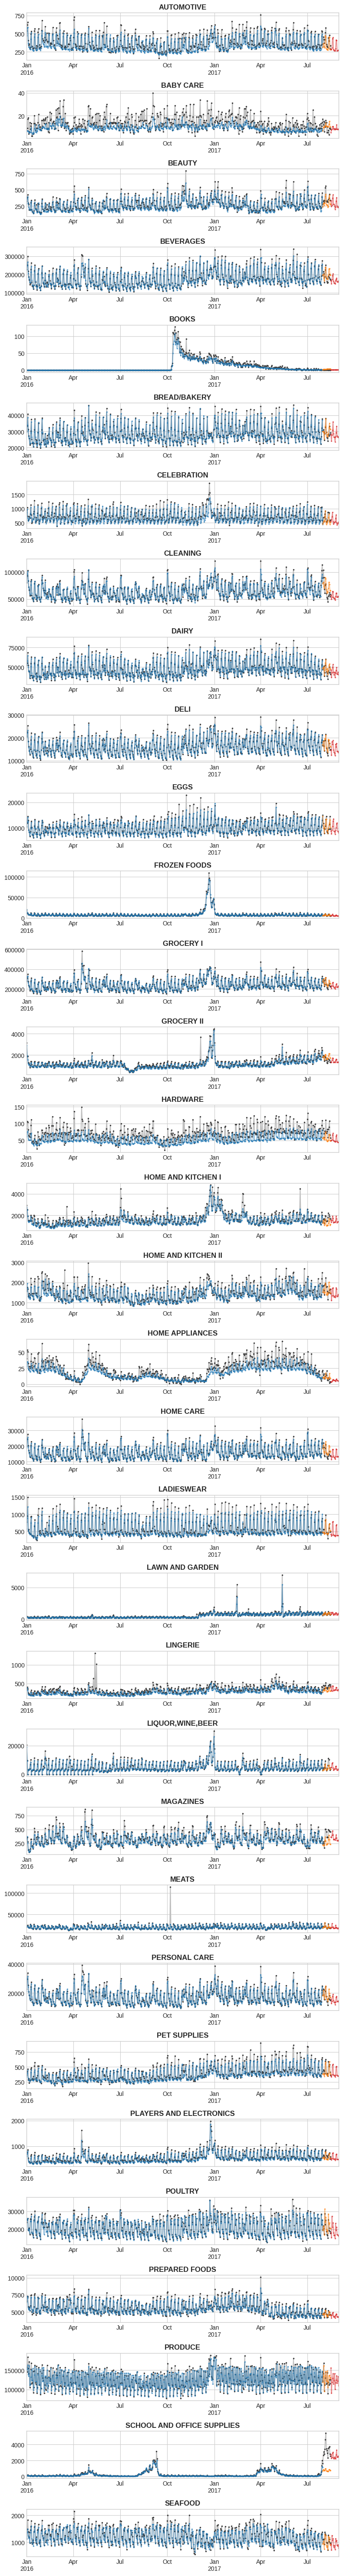

In [48]:
if RUN_LGBMR and RUN_FORECAST:
    y_forecast_lgbmr = forecast_all(
        mod='lgbmr',
        df_per_store=X_per_store,
        df_common=X_common,
        y_all=y_all,
        mod_params=model_params,
        train_end=train_end,
        test_start=test_start,
        family_list=family_list,
        n_jobs=-1,
    )
    y_forecast_final = y_forecast_lgbmr

    if DO_PLOTS:
        plot_predictions(
            y_all.loc[:train_end],
            family_list,
            store_number=None,
            start_date='2016-01-01',
            y_fit=y_fit_lgbmr,
            y_val=y_pred_val_lgbmr,
            y_fore=y_forecast_lgbmr,
            fit_last_date=fit_last_date_lgbmr,
        )
else:
    y_forecast_lgbmr = None

# Ensemble models

In [49]:
VALIDATE_OPTIMIZED_MODELS = False
FORECAST_OPTIMIZED_MODELS = True

## Validate ensemble models

In [50]:
# the version submitted to Kaggle has fewer models and takes much less time to run
# but performance is worse

models_to_validate = []

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 0
mod_to_val['params']['lag_list']['target']['max'] = 63
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 0
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 0
mod_to_val['params']['lag_list']['target']['max'] = 730
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 730
mod_to_val['params']['lag_list']['target']['max'] = 180
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 730
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1095
mod_to_val['params']['lag_list']['target']['max'] = 180
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1095
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1095
mod_to_val['params']['lag_list']['target']['max'] = 730
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1275
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'lgbmr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1275
mod_to_val['params']['lag_list']['target']['max'] = 730
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'cbr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 730
mod_to_val['params']['lag_list']['target']['max'] = 180
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'cbr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 730
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'cbr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1095
mod_to_val['params']['lag_list']['target']['max'] = 365
models_to_validate.append(mod_to_val)

mod_to_val = {'name': 'cbr', 'params': copy.deepcopy(model_params)}
mod_to_val['params']['skip_first_n_days'] = 1095
mod_to_val['params']['lag_list']['target']['max'] = 730
models_to_validate.append(mod_to_val)

In [51]:
if VALIDATE_OPTIMIZED_MODELS:
    opt_models_val_results = []
    for m2v in tqdm(models_to_validate):
        val_rmsle_lgbmr, y_pred_val_lgbmr = validate_all(
            mod=m2v['name'],
            df_per_store=X_per_store,
            df_common=X_common,
            y_all=y_all,
            mod_params=m2v['params'],
            train_end=train_end,
            test_start=test_start,
            validation_len=validation_len,
            validation_folds=validation_folds,
            family_list=family_list,
            n_jobs=-1,
            return_preds=True,
            print_fam_rmsle=False,
        )
        fit_last_date_lgbmr = y_pred_val_lgbmr.index[0]
        opt_models_val_results.append(y_pred_val_lgbmr)
        print(f'{m2v["name"].ljust(5)} mean RMSLE: {val_rmsle_lgbmr:.5f}')

## Forecast using ensemble models

In [52]:
models_to_forecast = models_to_validate

if FORECAST_OPTIMIZED_MODELS:
    forecast_results = []
    for m2f in tqdm(models_to_forecast):
        m2f_forecast = forecast_all(
            mod=m2f['name'],
            df_per_store=X_per_store,
            df_common=X_common,
            y_all=y_all,
            mod_params=m2f['params'],
            train_end=train_end,
            test_start=test_start,
            family_list=family_list,
            n_jobs=-1,
        )
        forecast_results.append(m2f_forecast)

  0%|          | 0/14 [00:00<?, ?it/s]

In [53]:
if FORECAST_OPTIMIZED_MODELS:
    forecast_results_stack = [res.copy() for res in forecast_results]
    forecast_results_stack = [res.stack(['store_nbr', 'family']) for res in forecast_results_stack]
    for i in range(len(forecast_results_stack)):
        forecast_results_stack[i].name = f'res{i}'
    yff = pd.concat(forecast_results_stack, axis=1)
    yff['sales'] = yff.mean(axis=1)
    yff.drop(columns=[f'res{i}' for i in range(len(forecast_results_stack))], axis=1, inplace=True)
    yff = pd.Series(yff['sales'])
    yff = yff.unstack(['family', 'store_nbr'])
    yff.sort_index(axis=1, inplace=True)
    y_forecast_final = yff.copy()
    display(y_forecast_final)

family     AUTOMOTIVE                                                    \
store_nbr           1        10        11        12        13        14   
date                                                                      
2017-08-16   3.379603  1.432978  5.164815  4.097732  3.762327  2.588735   
2017-08-17   3.408026  1.473286  5.308075  4.487699  3.485462  2.597912   
2017-08-18   3.662339  1.596597  6.067299  4.233380  3.405574  2.570381   
2017-08-19   3.908555  1.824188  7.502696  5.243173  5.590934  4.513020   
2017-08-20   2.502852  1.806307  7.375106  5.653018  4.392304  3.566700   
2017-08-21   2.841539  1.537600  5.188711  4.105031  3.832530  2.807699   
2017-08-22   3.407957  1.548433  5.163884  3.664228  4.034208  2.491860   
2017-08-23   3.280345  1.353062  5.062248  3.916502  3.522285  2.595900   
2017-08-24   3.046783  1.433255  5.524740  3.996150  3.528080  2.352613   
2017-08-25   3.523536  1.552570  6.195064  4.023667  3.890011  2.971112   
2017-08-26   3.754232  1.808508  8.371779  5.936723  5.272492  4.604709   
2017-08-27   1.892130  1.652361  7.263713  5.501814  4.677941  3.562298   
2017-08-28   3.258481  1.629989  4.886512  4.264043  3.765123  3.153294   
2017-08-29   3.137348  1.583690  4.738183  3.370706  3.658829  2.526526   
2017-08-30   3.296609  2.246663  4.953072  3.608482  3.685228  2.748249   
2017-08-31   3.213879  1.077537  5.247848  4.121699  3.652408  2.649997   

family                                              ...    SEAFOOD             \
store_nbr         15        16        17        18  ...          5         50   
date                                                ...                         
2017-08-16  3.030865  3.309580  6.094099  2.934347  ...   9.187724  14.693268   
2017-08-17  2.601822  3.202285  5.259494  3.004172  ...   8.807183  13.704471   
2017-08-18  3.024788  3.647689  6.022790  3.124689  ...  13.739444  18.586078   
2017-08-19  4.005367  4.146859  9.331894  4.643815  ...   8.021825  18.859821   
2017-08-20  5.118860  4.616993  8.495354  4.446290  ...   9.204257  22.293597   
2017-08-21  2.944893  3.532981  6.983204  2.433398  ...   8.093874  14.642314   
2017-08-22  2.970516  3.338646  5.698373  2.566836  ...   8.257547  13.567931   
2017-08-23  2.336599  2.869942  5.359140  2.639178  ...   8.985107  14.693741   
2017-08-24  2.471895  3.062130  5.367534  2.735208  ...  10.509100  13.795766   
2017-08-25  2.676537  3.160503  5.696400  2.827771  ...  13.353682  18.250935   
2017-08-26  3.661398  4.411822  8.658425  4.271218  ...   8.439629  18.829483   
2017-08-27  3.486078  5.067135  7.939709  4.136431  ...  10.537161  19.147808   
2017-08-28  3.918696  3.203490  6.051324  2.455241  ...   9.494223  13.880678   
2017-08-29  2.865796  2.991156  5.637223  2.399772  ...  10.079303  14.055648   
2017-08-30  2.438951  4.105699  5.828155  2.560710  ...   9.858621  14.563773   
2017-08-31  2.379529  2.714416  5.336884  2.724558  ...  10.362675  14.028321   

family                                                                      \
store_nbr          51         52        53        54          6          7   
date                                                                         
2017-08-16  45.521130   6.551376  3.770061  1.815160  35.692120  47.564315   
2017-08-17  36.313870   6.911672  3.003532  1.249499  25.086179  35.086407   
2017-08-18  73.872298   9.784654  4.010741  0.977535  55.683902  56.120494   
2017-08-19  47.784526   8.781356  3.836072  2.371625  40.307955  37.518897   
2017-08-20  51.194654   7.634094  3.744329  1.989699  52.433938  37.705409   
2017-08-21  43.121869   6.588133  3.175818  1.443516  34.311938  44.483709   
2017-08-22  37.036746   6.620125  2.880767  2.252766  30.675675  40.609418   
2017-08-23  44.459780   8.136528  2.995043  1.788699  32.614474  46.659847   
2017-08-24  35.637364   6.434167  2.698470  1.498112  26.145516  36.693051   
2017-08-25  58.179051  10.961858  4.251670  1.023885  48.880457  55.199119   
2017-08-26  45.81152

# Submission

```
kaggle competitions submit -c store-sales-time-series-forecasting -f submission.csv -m "message"
kaggle competitions submissions -c store-sales-time-series-forecasting
```

Score obtained by this version: `0.38538`

In [54]:
def create_submission(test_df, y_forecast):
    test_df = test_df.copy()
    y_forecast = y_forecast.copy()
    y_forecast = y_forecast.stack(['store_nbr', 'family'])
    # display(y_forecast.head(40))
    test_df['store_nbr'] = test_df['store_nbr'].astype(str).astype('category')
    test_df['family'] = test_df['family'].astype('category')
    test_df.set_index(['date', 'store_nbr', 'family'], inplace=True)
    my_submission = (
        pd.concat([test_df, y_forecast], axis=1)
        .drop(columns=['onpromotion'])
        .rename(columns={0: 'sales'})
        .reset_index()
        .drop(columns=['date', 'store_nbr', 'family'])
        .set_index(['id'])
    )
    sample_submission = pd.read_csv(input_dir / 'sample_submission.csv', index_col='id').drop(columns='sales')
    submission = sample_submission.merge(my_submission, on='id')
    return submission


if y_forecast_final is not None:
    submission = create_submission(test_df, y_forecast_final)
    submission.to_csv('submission.csv')
    display(submission)

sales
id                  
3000888     3.379603
3000889     0.000000
3000890     4.239763
3000891  2363.618954
3000892     0.023761
...              ...
3029395   357.776958
3029396    93.457158
3029397  1528.526569
3029398   115.679754
3029399    12.707915

[28512 rows x 1 columns]